<a href="https://colab.research.google.com/github/Salvoaf/BreastCancerClassification/blob/main/2.%20Pre_trained_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import files
files.upload()
!pip install kaggle
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/breast-histopathology-images
!unzip breast-histopathology-images.zip

In [2]:
import os
from google.colab import drive
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras import layers, models, optimizers
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
import random as rn


In [6]:
breast_img = glob.glob('/content/IDC_regular_ps50_idx5/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

/content/IDC_regular_ps50_idx5/10264/0/10264_idx5_x1651_y501_class0.png
/content/IDC_regular_ps50_idx5/10264/0/10264_idx5_x451_y2051_class0.png
/content/IDC_regular_ps50_idx5/10264/0/10264_idx5_x2101_y201_class0.png


Split of the dataset

In [7]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)
    
    elif img[-5] == '1' :
        P_IDC.append(img)

In [8]:
non_num = len(N_IDC)
can_num = len(P_IDC)
        
total_img_num = non_num + can_num
        
print('Number of Images in IDC (-): {}' .format(non_num))
print('Number of Images in IDC (+) : {}' .format(can_num))
print('Total Number of Images : {}' .format(total_img_num))

Number of Images in IDC (-): 198738
Number of Images in IDC (+) : 78786
Total Number of Images : 277524


In [9]:
# Create two empty arrays to store the processed images and their labels
non_img_arr = []
can_img_arr = []

# Loop through the list of file names in N_IDC
for img in N_IDC:
    
    # Read the image using OpenCV's imread function
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    
    # Resize the image to 50x50 using OpenCV's resize function
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    
    # Add the resized image and label (0) to the non_img_arr list
    non_img_arr.append([n_img_size, 0])
    
# Loop through the list of file names in P_IDC
for img in P_IDC:
    # Read the image using OpenCV's imread function
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    
    # Resize the image to 50x50 using OpenCV's resize function
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    
    # Add the resized image and label (1) to the can_img_arr list
    can_img_arr.append([c_img_size, 1])

In [10]:
from IPython.core.interactiveshell import Integer
print(f"negative: {len(non_img_arr)} with perc: {(1-len(can_img_arr)/len(non_img_arr))*100}%, positive: {len(can_img_arr)} with perc: {(len(can_img_arr)/len(non_img_arr))*100}%")
length = int(len(non_img_arr))
train_non_img_arr = non_img_arr[:int(0.6 * length)]
validation_non_img_arr = non_img_arr[int(0.6 * length): int(0.8 * length)]
test_non_img_arr = non_img_arr[int(0.8 * length):int(length)]
print(f"len of train_negative: {len(train_non_img_arr)}, len of validation_negative: {len(validation_non_img_arr)}, len of test_negative: {len(test_non_img_arr)} ")

length = int(len(can_img_arr))
train_can_img_arr = can_img_arr[:int(0.6 * length)]
validation_can_img_arr = can_img_arr[int(0.6 * length): int(0.8 * length)]
test_can_img_arr = can_img_arr[int(0.8 * length):int(length)]
print(f"len of train_positive: {len(train_can_img_arr)}, len of validation_positive: {len(validation_can_img_arr)}, len of test_positive: {len(test_can_img_arr)} ")

length = len(train_can_img_arr)
random.shuffle(train_non_img_arr)
train_non_img_arr = train_non_img_arr[:int(length)]
print(f"new len of train_negative {len(train_non_img_arr)}. Now, the len of postive and negative sample is same")


train = np.concatenate((train_non_img_arr,train_can_img_arr))
validation = np.concatenate((validation_non_img_arr,validation_can_img_arr))
test = np.concatenate((test_non_img_arr,test_can_img_arr))

train_idx = np.random.permutation(train.shape[0])
train = train[train_idx]

validation_idx = np.random.permutation(validation.shape[0])
validation = validation[validation_idx]

test_idx = np.random.permutation(test.shape[0])
test = test[test_idx]


negative: 198738 with perc: 60.35685173444434%, positive: 78786 with perc: 39.64314826555565%
len of train_negative: 119242, len of validation_negative: 39748, len of test_negative: 39748 
len of train_positive: 47271, len of validation_positive: 15757, len of test_positive: 15758 
new len of train_negative 47271. Now, the len of postive and negative sample is same


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [11]:
X_train = []
X_test = []
X_val = []
Y_train = []
Y_test = [] 
Y_val = []


for feature, label in train:
    X_train.append(feature)
    Y_train.append(label)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

for feature, label in validation:
    X_val.append(feature)
    Y_val.append(label)
X_val = np.array(X_val)
Y_val = np.array(Y_val)

for feature, label in test:
    X_test.append(feature)
    Y_test.append(label)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [12]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
Y_val = to_categorical(Y_val, num_classes = 2)


print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (94542, 50, 50, 3)
Validation Data Shape: (55505, 50, 50, 3)
Testing Data Shape: (55506, 50, 50, 3)


In [13]:
import shutil

local_model_path = "/content/models"
if not os.path.exists(local_model_path):
  os.makedirs(local_model_path)
global_model_path = "/content/drive/My Drive/models/vgg16"
if not os.path.exists(global_model_path):
  os.makedirs(global_model_path)
global_model_path_report = "/content/drive/My Drive/report/vgg16"
if not os.path.exists(global_model_path_report):
  os.makedirs(global_model_path_report)

# Set function for treaning

In [14]:
def set_seed ():
  ''' 
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  seed = 24
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]="0"
  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(seed)
  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(seed)
  # The below tf.random.set_seed will make x number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(seed)

In [15]:
set_seed()

In [16]:
from keras.callbacks import Callback
from tensorflow.keras import optimizers
from sklearn import metrics
from sklearn.metrics import confusion_matrix

def compile_model(model, optimizer='adam', learning_rate = 0.0001):
  '''
  compile_model is used to compile the current model
  :param model: model to be compiled
  :param optimizer: optimizer to be used
  :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])
  elif optimizer == 'rmsprop':
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
  model.summary()


def save_metrics_to_csv(table, title, filepath):
    """Append a metric table to a CSV file."""
    if not os.path.exists(filepath):
      with open(filepath, 'w') as f:
        f.write('') 

    table = pd.DataFrame(table)
    with open(filepath, 'a') as f:
      # Write the title and table to the CSV file
      table.to_csv(f, index=False)
      f.write('\n')

def describe_training_and_validation_performance(history,model):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()


def run_training(model, model_name, num_epochs = 20, patience=5, monitor='val_loss'):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_model = f'{local_model_path}/{model_name}.h5'
  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_model,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(X_train, Y_train,
                    epochs=num_epochs,
                    validation_data=(X_val, Y_val),
                    callbacks=callbacks_list)
  # save on Drive only the best model
  shutil.copy(save_model, f'{global_model_path}/{model_name}.h5')
  describe_training_and_validation_performance(history,model_name)

def evaluate_performance(model, title):
    """
    The function is used to evaluate the performance of a given model on a test dataset and display a
    classification report and a ROC curve.

    :param model: The model to be evaluated
    """
    # Get the predicted scores and round them to the nearest integer

    y_score = model.predict(X_test)
    y_pred = np.argmax(y_score,axis = 1) 
    y_true = np.argmax(Y_test,axis = 1) 

    print("Report di classificazione:")
    report = metrics.classification_report(y_true, y_pred, digits=4)
    print(report)

    precision_0, recall_0, f1_score_0 = report.split()[5:8]
    precision_1, recall_1, f1_score_1 = report.split()[-19:-16]
    accuracy = report.split()[-14:-13]


    metric_table = [['name model', title],
            ['', 'precision', 'recall', 'f1-score'],
            ['0', precision_0, recall_0, f1_score_0 ],
            ['1', precision_1, recall_1, f1_score_1 ],
            ['accuracy', accuracy[0]]]

    filepath = f'{global_model_path_report}/report.csv'
    save_metrics_to_csv(metric_table, model, filepath)

    matrice_di_confusione = confusion_matrix(y_true, y_pred)
    print("Matrice di confusione:")
    print(matrice_di_confusione)

    # Print a classification report
    print("Classification report:")
    print(metrics.classification_report(y_true, y_pred, digits=4))
    metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

    # Compute the false positive rate and true positive rate for the ROC curve
    fpr, tpr, th = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.roc_auc_score(y_true, y_pred)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()


#Functions to display difference between model and real results 

In [17]:
def extract_coords(df):
  coord = df.path.str.rsplit("_", n=4, expand=True)
  coord = coord.drop([0, 1, 4], axis=1)
  coord = coord.rename({2: "x", 3: "y"}, axis=1)
  coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(int)
  coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(int)
  df.loc[:, "x"] = coord.x.values
  df.loc[:, "y"] = coord.y.values
  return df

def get_cancer_dataframe(patient_id, cancer_id):
  base_path = "/content/IDC_regular_ps50_idx5/"
  path = base_path + patient_id + "/" + cancer_id
  files = listdir(path)
  dataframe = pd.DataFrame(files, columns=["filename"])
  path_names = path + "/" + dataframe.filename.values
  dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
  dataframe.loc[:, "target"] = int(cancer_id)
  dataframe.loc[:, "path"] = path_names
  dataframe = dataframe.drop([0, 1, 4], axis=1)
  dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
  dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(int)
  dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(int)
  return dataframe

def get_patient_dataframe(patient_id):
  df_0 = get_cancer_dataframe(patient_id, "0")
  df_1 = get_cancer_dataframe(patient_id, "1")
  patient_df = df_0.append(df_1)
  return patient_df

def visualise_breast_tissue_base(patient_id, pred_df=None, trained_df=None):
  if isinstance(trained_df, pd.DataFrame):
    example_df = trained_df
  else:
    example_df = get_patient_dataframe(patient_id)

  max_point = [example_df.y.max()-1, example_df.x.max()-1]
  grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
  mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
  if pred_df is not None:
      patient_df = pred_df[pred_df.patient_id == patient_id].copy()
  mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(float)
  
  broken_patches = []
  for n in range(len(example_df)):
      try:
          image = cv2.imread(example_df.path.values[n])
          
          target = example_df.target.values[n]
          
          x_coord = int(example_df.x.values[n])
          y_coord = int(example_df.y.values[n])
          x_start = x_coord - 1
          y_start = y_coord - 1
          x_end = x_start + 50
          y_end = y_start + 50

          grid[y_start:y_end, x_start:x_end] = image
          if target == 1:
              mask[y_start:y_end, x_start:x_end, 0] = 250
              mask[y_start:y_end, x_start:x_end, 1] = 0
              mask[y_start:y_end, x_start:x_end, 2] = 0
          if pred_df is not None:
              
              proba = patient_df[
                  (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
              mask_proba[y_start:y_end, x_start:x_end, 0] = float(proba)

      except ValueError:
          broken_patches.append(example_df.path.values[n])
  
  
  return grid, mask, broken_patches, mask_proba

#visualizzo immagine
def visualise_breast_tissue(patient_id, trained_df = None):
  grid, mask, broken_patches,_ = visualise_breast_tissue_base(patient_id, trained_df=trained_df)

  fig, ax = plt.subplots(1,2,figsize=(20,10))
  ax[0].imshow(grid, alpha=0.9)
  ax[1].imshow(mask, alpha=0.8)
  ax[1].imshow(grid, alpha=0.7)
  ax[0].grid(False)
  ax[1].grid(False)
  for m in range(2):
      ax[m].set_xlabel("X-coord")
      ax[m].set_ylabel("Y-coord")
  if isinstance(trained_df, pd.DataFrame):
    ax[0].set_title("Breast tissue slice of patient: " + patient_id)
    ax[1].set_title("Cancer tissue predicted colored red \n of patient: " + patient_id);
  else:
    ax[0].set_title("Breast tissue slice of patient: " + patient_id)
    ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);

#estraggo coordinate,label, percorso dell'immagine, feature immagine 
def extract_main_feature(patient_id, typ=None):
  example_df = get_patient_dataframe(patient_id)

  Y_test = example_df["target"].to_numpy()
  x_coord= example_df["x"].to_numpy()
  y_coord= example_df["y"].to_numpy()
  path_images = example_df["path"].to_numpy()
  X_test = []
      

  if typ == "CLAHE":
    # Crea un'istanza di CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    for path_img in path_images:
      
      # Read the image using OpenCV's imread function
      n_img = cv2.imread(path_img, cv2.IMREAD_COLOR)

      # Split the image into its individual color channels
      b, g, r = cv2.split(n_img)
      
      # Apply CLAHE to each color channel
      b = clahe.apply(b)
      g = clahe.apply(g)
      r = clahe.apply(r)

      # Merge the CLAHE-processed color channels back into an RGB image
      n_img = cv2.merge((b, g, r))
      
      # Resize the image to 50x50 using OpenCV's resize function
      n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)      
      # Add the resized image and label (0) to the non_img_arr list
      X_test.append(n_img_size)
  else:
    for path_img in path_images:
        
        # Read the image using OpenCV's imread function
        img = cv2.imread(path_img, cv2.IMREAD_COLOR)
        
        # Resize the image to 50x50 using OpenCV's resize function
        img_size = cv2.resize(img, (50, 50), interpolation = cv2.INTER_LINEAR)
        
        # Add the resized image and label (0) to the non_img_arr list
        X_test.append(img_size)
  X_test = np.array(X_test)
  return x_coord,y_coord,Y_test,path_images, X_test

#prende le feature immagine e mi predice i label
def visualise_breast_tissue_predict(model, x_coord,y_coord,Y_test,path_images, X_test):
  model = tf.keras.models.load_model(f'{global_model_path}/{model}')
  y_score = model.predict(X_test)
  y_pred = np.argmax(y_score,axis = 1)  

  # Crea un dizionario che associa i nomi delle colonne alle colonne stesse come array numpy
  data = {'x': x_coord, 'y': y_coord, 'target': y_pred, 'path': path_images}

  # Crea un DataFrame passando il dizionario
  example_df = pd.DataFrame(data)
  visualise_breast_tissue(patient_id, example_df)

def realty_vs_predict(patient_id,model, typ=None):
  x_coord,y_coord,Y_test,path_images, X_test= extract_main_feature(patient_id, typ)
  #visualise real image
  visualise_breast_tissue(patient_id)
  #visualize predicted image
  visualise_breast_tissue_predict(model,x_coord,y_coord,Y_test,path_images, X_test)

# Feature Extractor
This initial series of experiments focuses on utilizing the architecture of VGG16 merely as a feature extractor.

Let's instantiate the VGG16 model:

This creates an instance of the VGG16 architecture from the keras.applications module and sets it as conv_base. The architecture is loaded with pre-trained "ImageNet" weights, and it is set to not include the fully connected layers on top (by setting include_top=False). The input shape of the images to be processed by the network is specified as (50,50,3), which indicates that the images are 50x50 pixels with 3 color channels (RGB).





In [13]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(50,50,3)
)

58889256/58889256 [==============================] - 4s 0us/step


In [14]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

Since we want to perform feature extraction only, we need to "freeze" the convolutional basis.

If we do not set *conv_base.trainable* to *False*, the weights within the *conv_base* will be updated during the training process. This means that the representations already learned by the model will be modified during training, which could lead to a degradation in performance or overfitting of the model. In other words, setting *conv_base.trainable* to *False* ensures that the convolutional base model is not altered during training and its already learned representations are used as the basis for feature extraction.





In [15]:
from tensorflow.keras import layers
import tensorflow as tf

conv_base.trainable = False

# Experiments


## Locking Pre-trained Model Weights: conv_base.trainable = False

### Experiment 1: Basic
We can now attach a binary classifier to the frozen convolutional base. In this initial implementation, a fully connected layer with 256 neurons is directly connected to the convolutional base, and the output layer contains a single neuron with a softmax activation function.

In [ ]:
inputs = keras.Input(shape=(50,50,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(2, activation="softmax")(x)
basic_model = keras.Model(inputs, outputs)
compile_model(basic_model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 50, 50, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 50, 50, 3)        0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                             

Epoch 1/15
2955/2955 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.7652
Epoch 1: val_loss improved from inf to 0.46506, saving model to /content/models/experiment1_basic.h5
2955/2955 [==============================] - 98s 30ms/step - loss: 0.6746 - accuracy: 0.7652 - val_loss: 0.4651 - val_accuracy: 0.8079
Epoch 2/15
2953/2955 [============================>.] - ETA: 0s - loss: 0.5159 - accuracy: 0.7760
Epoch 2: val_loss did not improve from 0.46506
2955/2955 [==============================] - 87s 30ms/step - loss: 0.5158 - accuracy: 0.7760 - val_loss: 0.5526 - val_accuracy: 0.7645
Epoch 3/15
2952/2955 [============================>.] - ETA: 0s - loss: 0.5136 - accuracy: 0.7755
Epoch 3: val_loss did not improve from 0.46506
2955/2955 [==============================] - 68s 23ms/step - loss: 0.5135 - accuracy: 0.7755 - val_loss: 0.4792 - val_accuracy: 0.8027
Epoch 4/15
2955/2955 [==============================] - ETA: 0s - loss: 0.5103 - accuracy: 0.7781
Epoch 4:

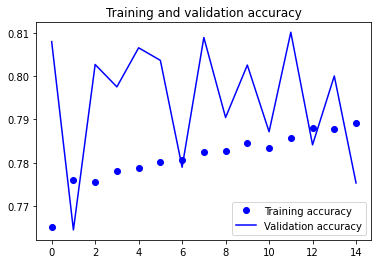

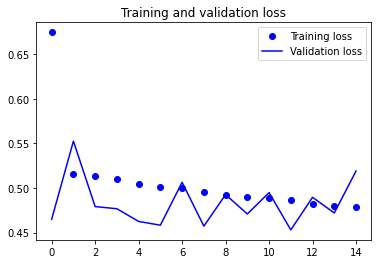

In [ ]:
run_training(basic_model, "experiment1_basic", num_epochs=15)

1735/1735 [==============================] - 22s 12ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.8773    0.8630    0.8701     39748
           1     0.6680    0.6955    0.6815     15758

    accuracy                         0.8154     55506
   macro avg     0.7726    0.7792    0.7758     55506
weighted avg     0.8179    0.8154    0.8165     55506

Matrice di confusione:
[[34302  5446]
 [ 4799 10959]]
Classification report:
              precision    recall  f1-score   support

           0     0.8773    0.8630    0.8701     39748
           1     0.6680    0.6955    0.6815     15758

    accuracy                         0.8154     55506
   macro avg     0.7726    0.7792    0.7758     55506
weighted avg     0.8179    0.8154    0.8165     55506



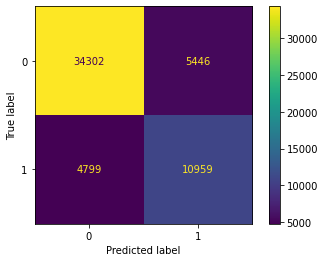

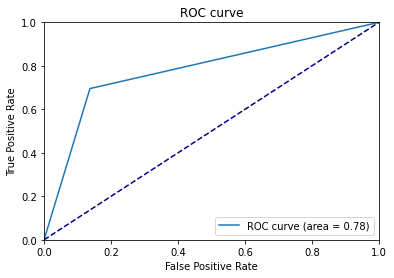

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/experiment1_basic.h5'),"experiment1_basic")

28/28 [==============================] - 1s 14ms/step


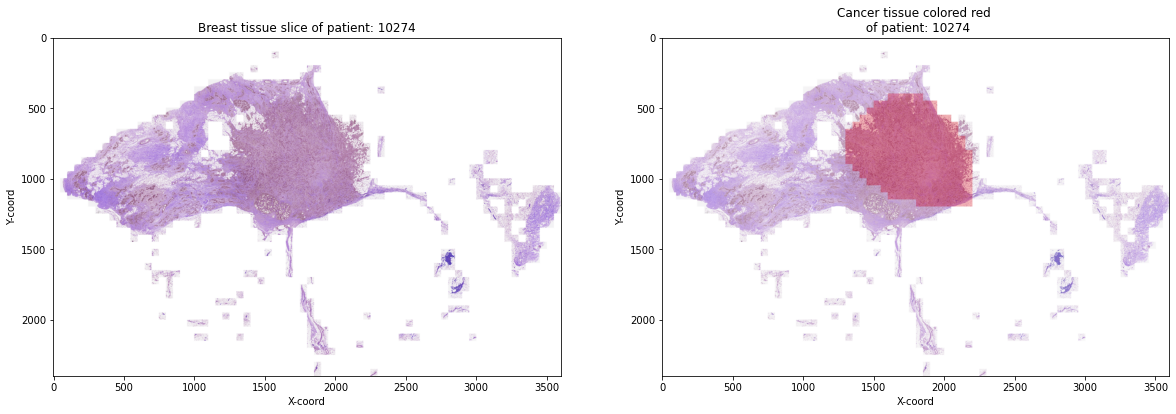

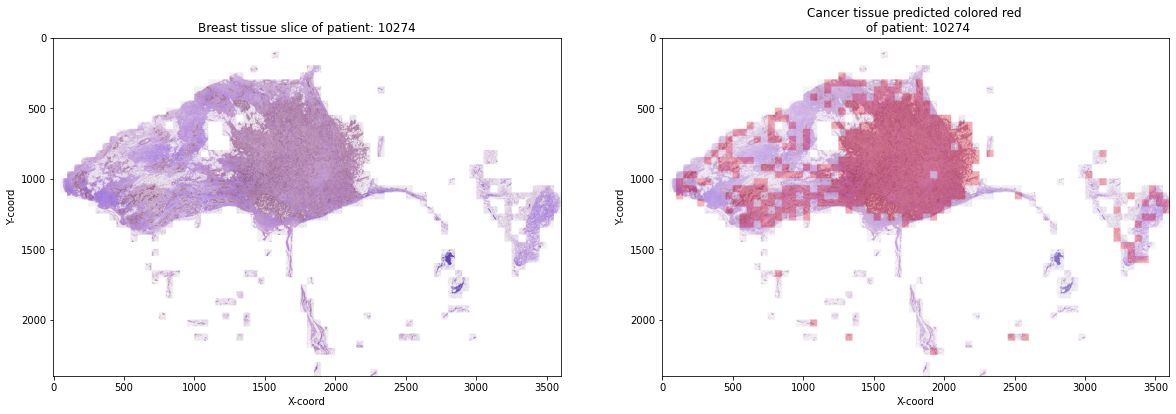

In [ ]:
patient_id = "10274"
model = "experiment1_basic.h5"
realty_vs_predict(patient_id,model)

### Experiment 2: Incorporating Dropout


In [ ]:
inputs = keras.Input(shape=(50,50,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)
basic_model = keras.Model(inputs, outputs)
compile_model(basic_model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem_2   (None, 50, 50, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 50, 50, 3)        0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328

Epoch 1/15
2952/2955 [============================>.] - ETA: 0s - loss: 2.4087 - accuracy: 0.7311
Epoch 1: val_loss improved from inf to 0.75377, saving model to /content/models/experiment2_dropout.h5
2955/2955 [==============================] - 68s 23ms/step - loss: 2.4076 - accuracy: 0.7311 - val_loss: 0.7538 - val_accuracy: 0.8001
Epoch 2/15
2955/2955 [==============================] - ETA: 0s - loss: 1.0821 - accuracy: 0.7540
Epoch 2: val_loss improved from 0.75377 to 0.51531, saving model to /content/models/experiment2_dropout.h5
2955/2955 [==============================] - 85s 29ms/step - loss: 1.0821 - accuracy: 0.7540 - val_loss: 0.5153 - val_accuracy: 0.7955
Epoch 3/15
2954/2955 [============================>.] - ETA: 0s - loss: 0.5695 - accuracy: 0.7755
Epoch 3: val_loss improved from 0.51531 to 0.48273, saving model to /content/models/experiment2_dropout.h5
2955/2955 [==============================] - 67s 23ms/step - loss: 0.5695 - accuracy: 0.7755 - val_loss: 0.4827 - val_a

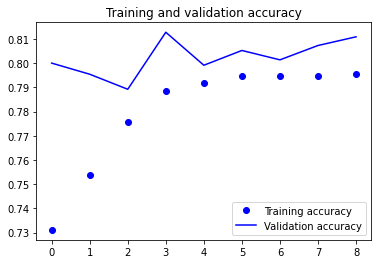

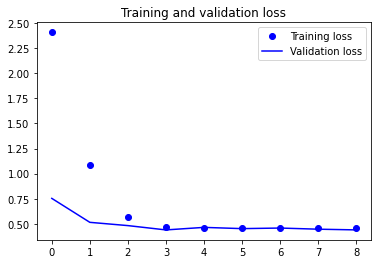

In [ ]:
run_training(basic_model, "experiment2_dropout", num_epochs=15)

1735/1735 [==============================] - 21s 12ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.8881    0.8566    0.8721     39748
           1     0.6680    0.7278    0.6966     15758

    accuracy                         0.8200     55506
   macro avg     0.7781    0.7922    0.7844     55506
weighted avg     0.8256    0.8200    0.8223     55506

Matrice di confusione:
[[34048  5700]
 [ 4289 11469]]
Classification report:
              precision    recall  f1-score   support

           0     0.8881    0.8566    0.8721     39748
           1     0.6680    0.7278    0.6966     15758

    accuracy                         0.8200     55506
   macro avg     0.7781    0.7922    0.7844     55506
weighted avg     0.8256    0.8200    0.8223     55506



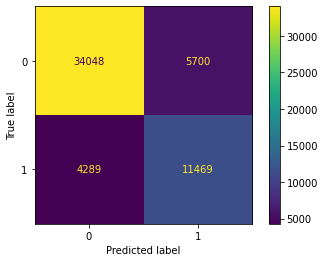

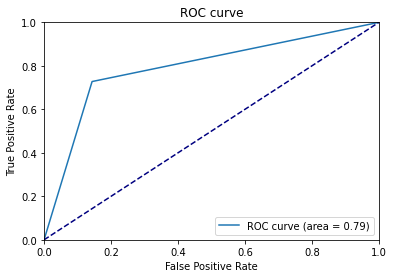

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/experiment2_dropout.h5'),"experiment2_dropout")

In [ ]:
patient_id = "10274"
model = "experiment2_dropout.h5"
realty_vs_predict(patient_id,model)

### Experiment 3: Global average pooling

In [ ]:
inputs = keras.Input(shape=(50,50,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)
basic_model = keras.Model(inputs, outputs)
compile_model(basic_model)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem_2   (None, 50, 50, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 50, 50, 3)        0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                           

Epoch 1/15
2954/2955 [============================>.] - ETA: 0s - loss: 2.4880 - accuracy: 0.7361
Epoch 1: val_loss improved from inf to 0.78198, saving model to /content/models/experiment3_dropout_globalAveragePool.h5
2955/2955 [==============================] - 89s 30ms/step - loss: 2.4879 - accuracy: 0.7361 - val_loss: 0.7820 - val_accuracy: 0.8079
Epoch 2/15
2955/2955 [==============================] - ETA: 0s - loss: 1.1124 - accuracy: 0.7570
Epoch 2: val_loss improved from 0.78198 to 0.47886, saving model to /content/models/experiment3_dropout_globalAveragePool.h5
2955/2955 [==============================] - 87s 29ms/step - loss: 1.1124 - accuracy: 0.7570 - val_loss: 0.4789 - val_accuracy: 0.8143
Epoch 3/15
2955/2955 [==============================] - ETA: 0s - loss: 0.5826 - accuracy: 0.7772
Epoch 3: val_loss improved from 0.47886 to 0.45070, saving model to /content/models/experiment3_dropout_globalAveragePool.h5
2955/2955 [==============================] - 86s 29ms/step - loss

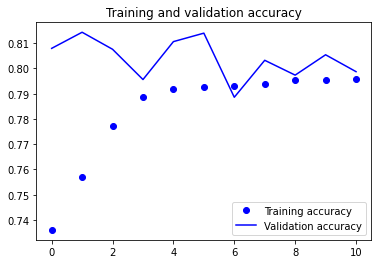

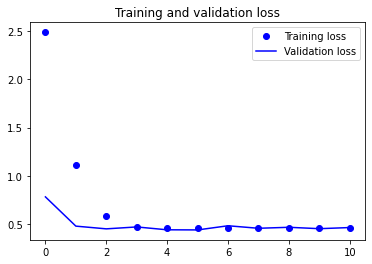

In [ ]:
run_training(basic_model, "experiment3_dropout_globalAveragePool", num_epochs=15)

1735/1735 [==============================] - 21s 12ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.8869    0.8598    0.8731     39748
           1     0.6717    0.7234    0.6966     15758

    accuracy                         0.8211     55506
   macro avg     0.7793    0.7916    0.7849     55506
weighted avg     0.8258    0.8211    0.8230     55506

Matrice di confusione:
[[34176  5572]
 [ 4359 11399]]
Classification report:
              precision    recall  f1-score   support

           0     0.8869    0.8598    0.8731     39748
           1     0.6717    0.7234    0.6966     15758

    accuracy                         0.8211     55506
   macro avg     0.7793    0.7916    0.7849     55506
weighted avg     0.8258    0.8211    0.8230     55506



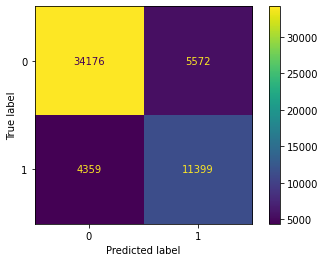

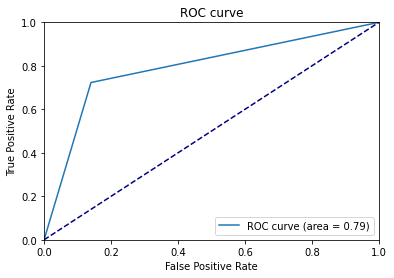

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/experiment3_dropout_globalAveragePool.h5'),"experiment3_dropout_globalAveragePool")

28/28 [==============================] - 1s 15ms/step


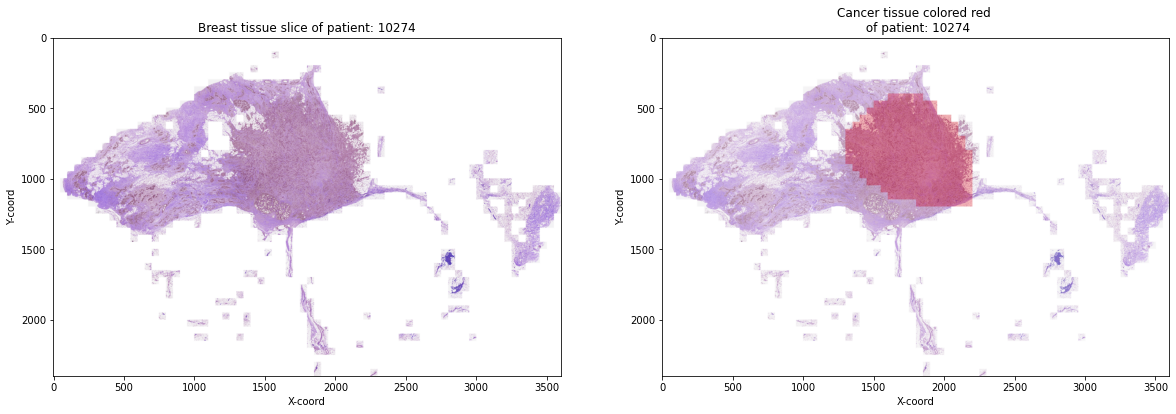

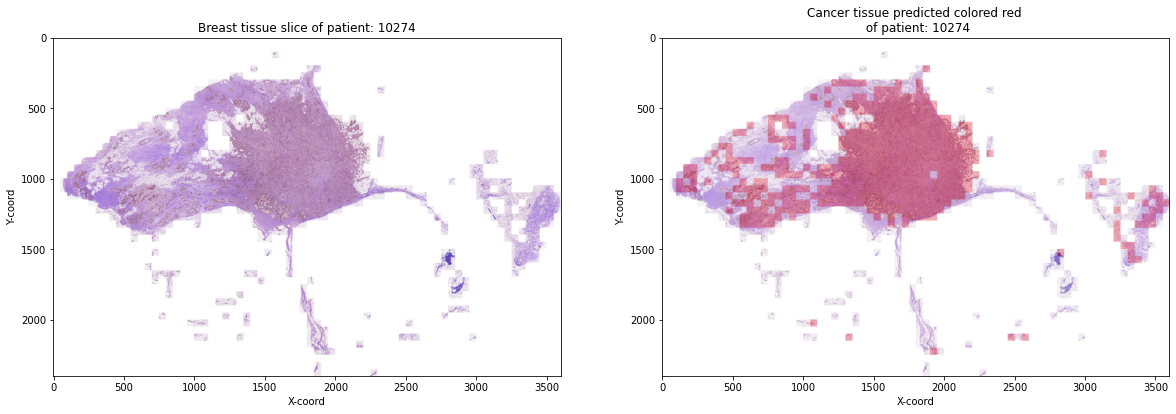

In [ ]:
patient_id = "10274"
model = "experiment3_dropout_globalAveragePool.h5"
realty_vs_predict(patient_id,model)

Down below we have the reports of our first 3 experiments in order by experiment, and we note that the second experiment is the one that went slightly better compared to the others.





## Improving Performance with Neural Network Fine-Tuning

###Experiment 4: last block (block5_conv3) with experiment1 


```
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_conv3 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_pool (MaxPooling2D)  (None, 6, 6, 256)         0         
                                                                 
 block4_conv1 (Conv2D)       (None, 6, 6, 512)         1180160   
                                                                 
 block4_conv2 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_conv3 (Conv2D)       (None, 6, 6, 512)         2359808   
                                                                 
 block4_pool (MaxPooling2D)  (None, 3, 3, 512)         0         
                                                                 
 block5_conv1 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 BLOCK5_CONV3 (Conv2D)       (None, 3, 3, 512)         2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 1, 1, 512)         0         
                                                                 
=================================================================
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________
```





Take first model with more treaning accuracy "experiment1_basic"

Leave all levels inalienable, except "***block5_conv3***" that will undergo changes to the weights

In [ ]:
from tensorflow.keras import layers, models, optimizers

vgg_ft_1_layer = models.load_model(os.path.join(global_model_path, 'experiment1_basic.h5'))

for layer in vgg_ft_1_layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_1_layer, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_1_layer.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 50, 50, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 50, 50, 3)        0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                             

Epoch 1/15
2954/2955 [============================>.] - ETA: 0s - loss: 0.4231 - accuracy: 0.8126
Epoch 1: val_loss improved from inf to 0.40688, saving model to /content/models/experiment4_fineTuning_block5_conv3 .h5
2955/2955 [==============================] - 96s 32ms/step - loss: 0.4231 - accuracy: 0.8125 - val_loss: 0.4069 - val_accuracy: 0.8264
Epoch 2/15
2954/2955 [============================>.] - ETA: 0s - loss: 0.3800 - accuracy: 0.8342
Epoch 2: val_loss did not improve from 0.40688
2955/2955 [==============================] - 93s 31ms/step - loss: 0.3800 - accuracy: 0.8342 - val_loss: 0.4306 - val_accuracy: 0.8150
Epoch 3/15
2954/2955 [============================>.] - ETA: 0s - loss: 0.3558 - accuracy: 0.8464
Epoch 3: val_loss did not improve from 0.40688
2955/2955 [==============================] - 92s 31ms/step - loss: 0.3559 - accuracy: 0.8463 - val_loss: 0.4203 - val_accuracy: 0.8203
Epoch 4/15
2954/2955 [============================>.] - ETA: 0s - loss: 0.3327 - accura

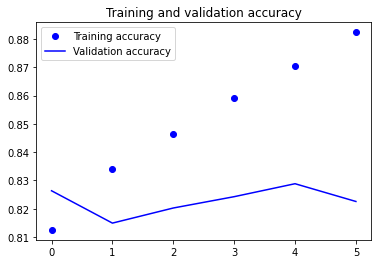

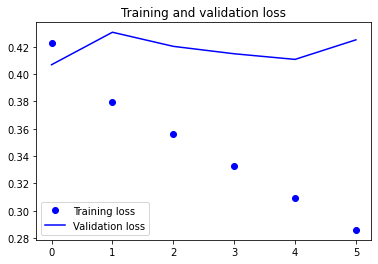

In [ ]:
run_training(vgg_ft_1_layer, 'experiment4_fineTuning_block5_conv3 ', num_epochs = 15, patience=5, monitor='val_loss')

1735/1735 [==============================] - 21s 12ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.9047    0.8625    0.8831     39748
           1     0.6897    0.7707    0.7280     15758

    accuracy                         0.8365     55506
   macro avg     0.7972    0.8166    0.8055     55506
weighted avg     0.8436    0.8365    0.8391     55506

Matrice di confusione:
[[34284  5464]
 [ 3613 12145]]
Classification report:
              precision    recall  f1-score   support

           0     0.9047    0.8625    0.8831     39748
           1     0.6897    0.7707    0.7280     15758

    accuracy                         0.8365     55506
   macro avg     0.7972    0.8166    0.8055     55506
weighted avg     0.8436    0.8365    0.8391     55506



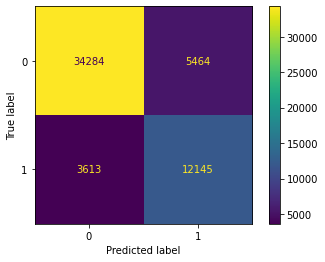

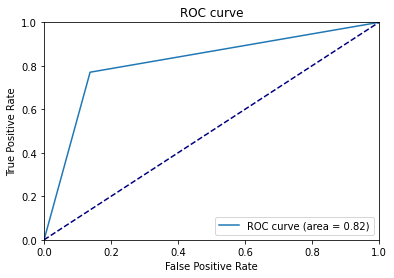

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/experiment4_fineTuning_block5_conv3 .h5'),"experiment4_fineTuning_block5_conv3")

28/28 [==============================] - 1s 15ms/step


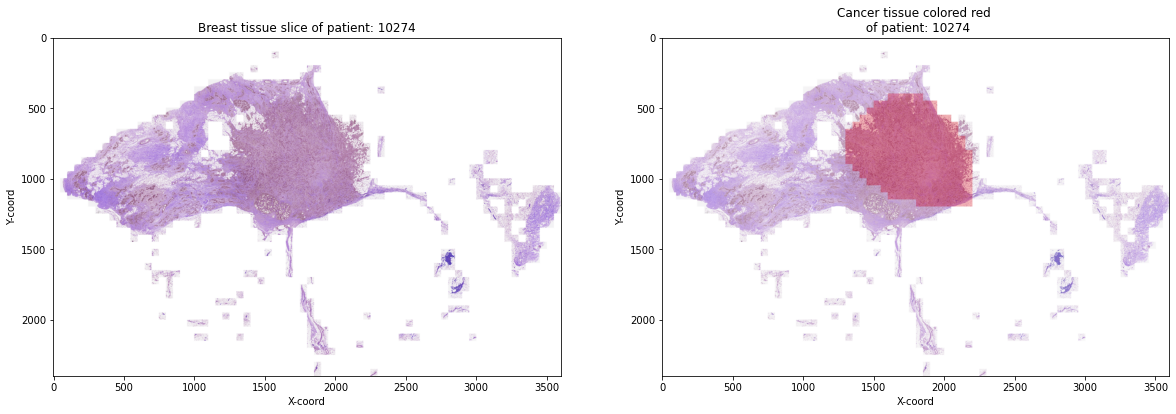

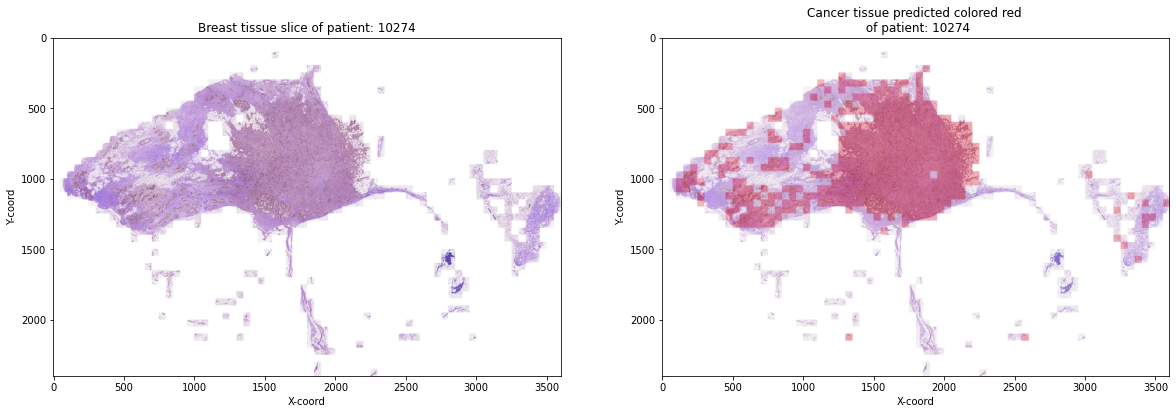

In [ ]:
patient_id = "10274"
model = "experiment4_fineTuning_block5_conv3 .h5"
realty_vs_predict(patient_id,model)

###Experiment 4bis last block (block5_conv3) with experiment2

In [ ]:
vgg_ft_1_layer = models.load_model(os.path.join(global_model_path, 'experiment2_dropout.h5'))

for layer in vgg_ft_1_layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_1_layer, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_1_layer.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem_1   (None, 50, 50, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 50, 50, 3)        0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               1313

Epoch 1/15
2955/2955 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.7588
Epoch 1: val_loss improved from inf to 0.48133, saving model to /content/models/experiment4bis_fineTuning_block5_conv3.h5
2955/2955 [==============================] - 105s 32ms/step - loss: 0.9798 - accuracy: 0.7588 - val_loss: 0.4813 - val_accuracy: 0.7916
Epoch 2/15
2955/2955 [==============================] - ETA: 0s - loss: 0.5127 - accuracy: 0.7915
Epoch 2: val_loss improved from 0.48133 to 0.44848, saving model to /content/models/experiment4bis_fineTuning_block5_conv3.h5
2955/2955 [==============================] - 70s 24ms/step - loss: 0.5127 - accuracy: 0.7915 - val_loss: 0.4485 - val_accuracy: 0.7947
Epoch 3/15
2954/2955 [============================>.] - ETA: 0s - loss: 0.4451 - accuracy: 0.8099
Epoch 3: val_loss did not improve from 0.44848
2955/2955 [==============================] - 88s 30ms/step - loss: 0.4451 - accuracy: 0.8099 - val_loss: 0.4496 - val_accuracy: 0.7943
Epoch

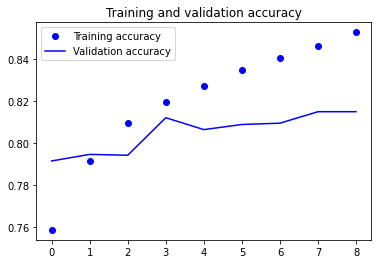

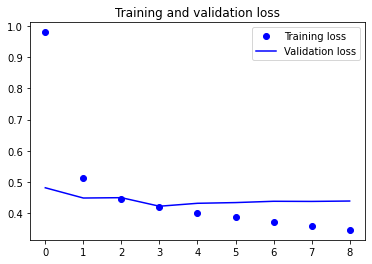

In [ ]:
run_training(vgg_ft_1_layer, 'experiment4bis_fineTuning_block5_conv3', num_epochs = 15, patience=5, monitor='val_loss')

1735/1735 [==============================] - 22s 12ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.9066    0.8280    0.8655     39748
           1     0.6439    0.7847    0.7074     15758

    accuracy                         0.8157     55506
   macro avg     0.7752    0.8064    0.7864     55506
weighted avg     0.8320    0.8157    0.8206     55506

Matrice di confusione:
[[32910  6838]
 [ 3392 12366]]
Classification report:
              precision    recall  f1-score   support

           0     0.9066    0.8280    0.8655     39748
           1     0.6439    0.7847    0.7074     15758

    accuracy                         0.8157     55506
   macro avg     0.7752    0.8064    0.7864     55506
weighted avg     0.8320    0.8157    0.8206     55506



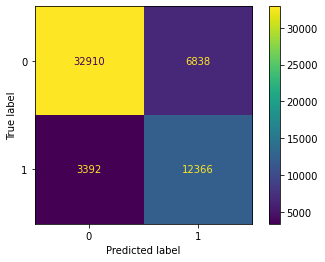

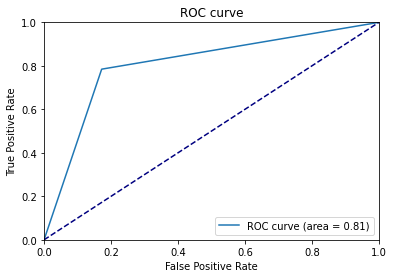

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/experiment4bis_fineTuning_block5_conv3.h5'),"experiment4bis_fineTuning_block5_conv3")

28/28 [==============================] - 1s 14ms/step


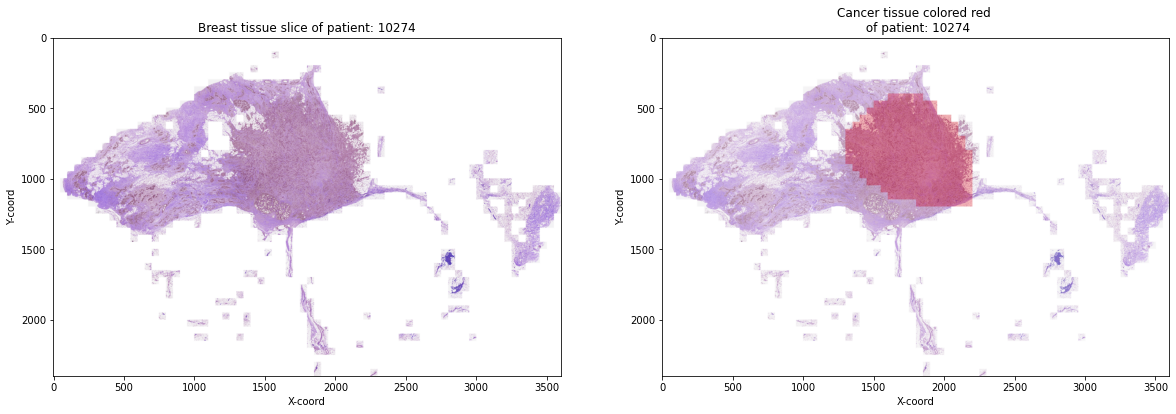

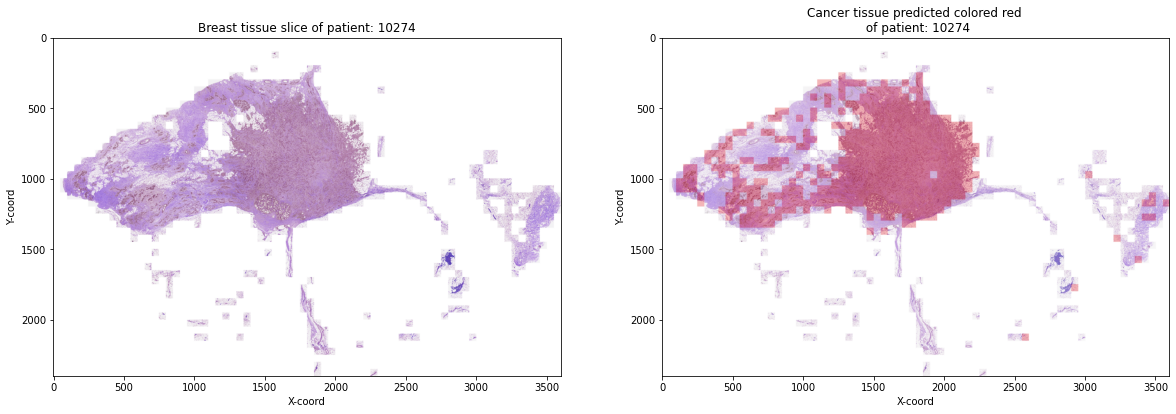

In [ ]:
patient_id = "10274"
model = "experiment4bis_fineTuning_block5_conv3.h5"
realty_vs_predict(patient_id,model)

### Experiment 5: last block (block5_conv2, block5_conv3, block5_conv1) with experiment1

Leave all levels inalienable, except "***block5_conv1, block5_conv2, block5_conv3***" that will undergo changes to the weights

In [ ]:
vgg_ft_1_layer = models.load_model(os.path.join(global_model_path, 'experiment1_basic.h5'))

for layer in vgg_ft_1_layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3', 'block5_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_1_layer, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_1_layer.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 50, 50, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 50, 50, 3)        0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                             

Epoch 1/15
2955/2955 [==============================] - ETA: 0s - loss: 0.3955 - accuracy: 0.8257
Epoch 1: val_loss improved from inf to 0.37952, saving model to /content/models/experiment5_fineTuning_block5_conv2__conv3__conv1.h5
2955/2955 [==============================] - 116s 35ms/step - loss: 0.3955 - accuracy: 0.8257 - val_loss: 0.3795 - val_accuracy: 0.8360
Epoch 2/15
2955/2955 [==============================] - ETA: 0s - loss: 0.3429 - accuracy: 0.8527
Epoch 2: val_loss did not improve from 0.37952
2955/2955 [==============================] - 84s 28ms/step - loss: 0.3429 - accuracy: 0.8527 - val_loss: 0.4101 - val_accuracy: 0.8204
Epoch 3/15
2953/2955 [============================>.] - ETA: 0s - loss: 0.3053 - accuracy: 0.8715
Epoch 3: val_loss did not improve from 0.37952
2955/2955 [==============================] - 87s 29ms/step - loss: 0.3053 - accuracy: 0.8715 - val_loss: 0.4389 - val_accuracy: 0.8114
Epoch 4/15
2955/2955 [==============================] - ETA: 0s - loss: 0

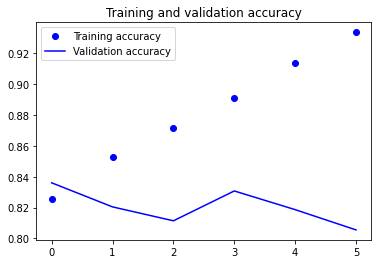

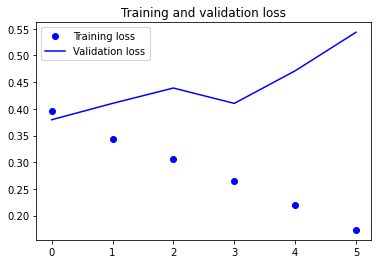

In [ ]:
run_training(vgg_ft_1_layer, 'experiment5_fineTuning_block5_conv2__conv3__conv1', num_epochs = 15, patience=5, monitor='val_loss')

1735/1735 [==============================] - 22s 13ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.9126    0.8690    0.8903     39748
           1     0.7051    0.7901    0.7452     15758

    accuracy                         0.8466     55506
   macro avg     0.8089    0.8296    0.8177     55506
weighted avg     0.8537    0.8466    0.8491     55506

Matrice di confusione:
[[34540  5208]
 [ 3307 12451]]
Classification report:
              precision    recall  f1-score   support

           0     0.9126    0.8690    0.8903     39748
           1     0.7051    0.7901    0.7452     15758

    accuracy                         0.8466     55506
   macro avg     0.8089    0.8296    0.8177     55506
weighted avg     0.8537    0.8466    0.8491     55506



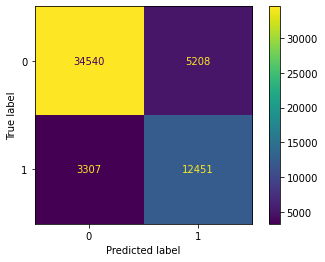

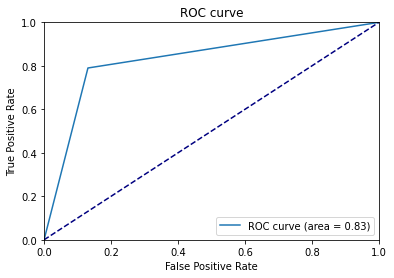

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/experiment5_fineTuning_block5_conv2__conv3__conv1.h5'),"experiment5_fineTuning_block5_conv2__conv3__conv1")

28/28 [==============================] - 1s 14ms/step


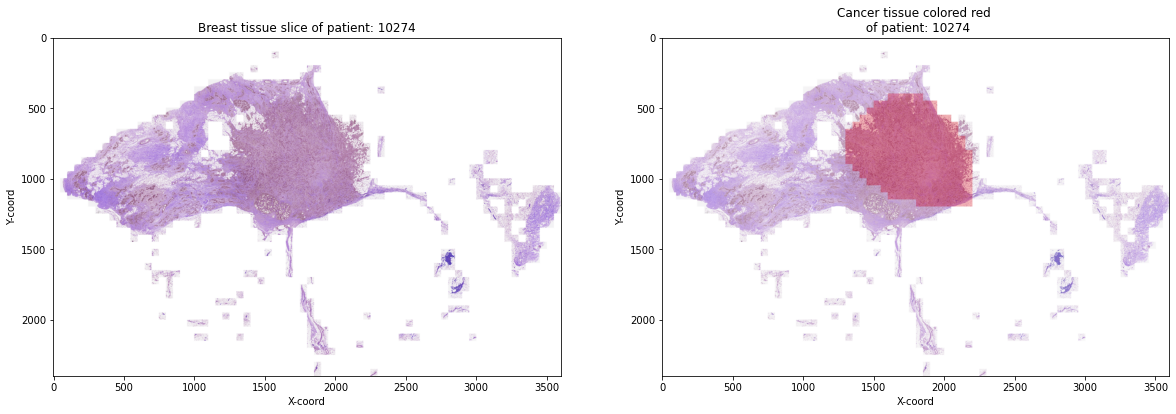

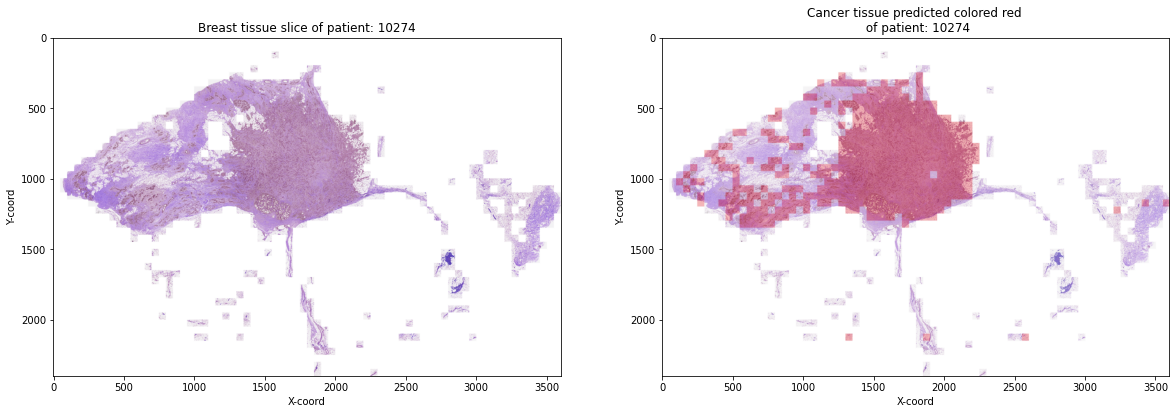

In [ ]:
patient_id = "10274"
model = "experiment5_fineTuning_block5_conv2__conv3__conv1.h5"
realty_vs_predict(patient_id,model)

### Experiment 5bis: last block (block5_conv2, block5_conv3, block5_conv1) with experiment2

In [ ]:
vgg_ft_1_layer = models.load_model(os.path.join(global_model_path, 'experiment2_dropout.h5'))

for layer in vgg_ft_1_layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3', 'block5_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_1_layer, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_1_layer.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem_2   (None, 50, 50, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 50, 50, 3)        0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328

Epoch 1/15
2955/2955 [==============================] - ETA: 0s - loss: 0.3977 - accuracy: 0.8246
Epoch 1: val_loss improved from inf to 0.38226, saving model to /content/models/experiment5bis_fineTuning_block5_conv2__conv3__conv1.h5
2955/2955 [==============================] - 108s 36ms/step - loss: 0.3977 - accuracy: 0.8246 - val_loss: 0.3823 - val_accuracy: 0.8319
Epoch 2/15
2955/2955 [==============================] - ETA: 0s - loss: 0.3490 - accuracy: 0.8497
Epoch 2: val_loss did not improve from 0.38226
2955/2955 [==============================] - 105s 35ms/step - loss: 0.3490 - accuracy: 0.8497 - val_loss: 0.4029 - val_accuracy: 0.8211
Epoch 3/15
2954/2955 [============================>.] - ETA: 0s - loss: 0.3148 - accuracy: 0.8664
Epoch 3: val_loss did not improve from 0.38226
2955/2955 [==============================] - 104s 35ms/step - loss: 0.3148 - accuracy: 0.8664 - val_loss: 0.4188 - val_accuracy: 0.8179
Epoch 4/15
2954/2955 [============================>.] - ETA: 0s - lo

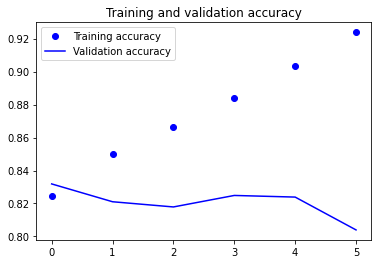

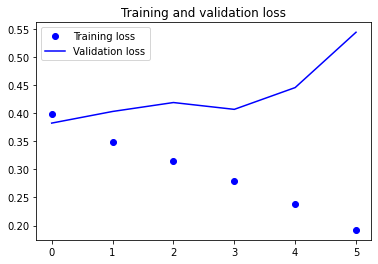

In [ ]:
run_training(vgg_ft_1_layer, 'experiment5bis_fineTuning_block5_conv2__conv3__conv1', num_epochs = 15, patience=5, monitor='val_loss')

1735/1735 [==============================] - 22s 13ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.9175    0.8594    0.8875     39748
           1     0.6942    0.8052    0.7456     15758

    accuracy                         0.8440     55506
   macro avg     0.8059    0.8323    0.8166     55506
weighted avg     0.8541    0.8440    0.8472     55506

Matrice di confusione:
[[34160  5588]
 [ 3070 12688]]
Classification report:
              precision    recall  f1-score   support

           0     0.9175    0.8594    0.8875     39748
           1     0.6942    0.8052    0.7456     15758

    accuracy                         0.8440     55506
   macro avg     0.8059    0.8323    0.8166     55506
weighted avg     0.8541    0.8440    0.8472     55506



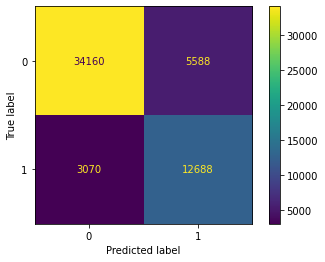

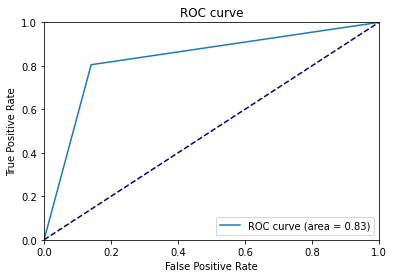

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/experiment5bis_fineTuning_block5_conv2__conv3__conv1.h5'),"experiment5bis_fineTuning_block5_conv2__conv3__conv1")

28/28 [==============================] - 1s 15ms/step


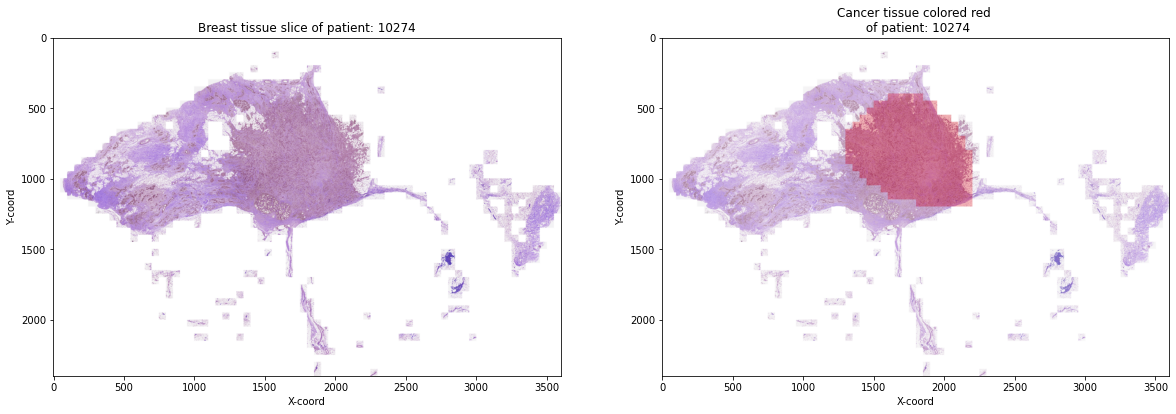

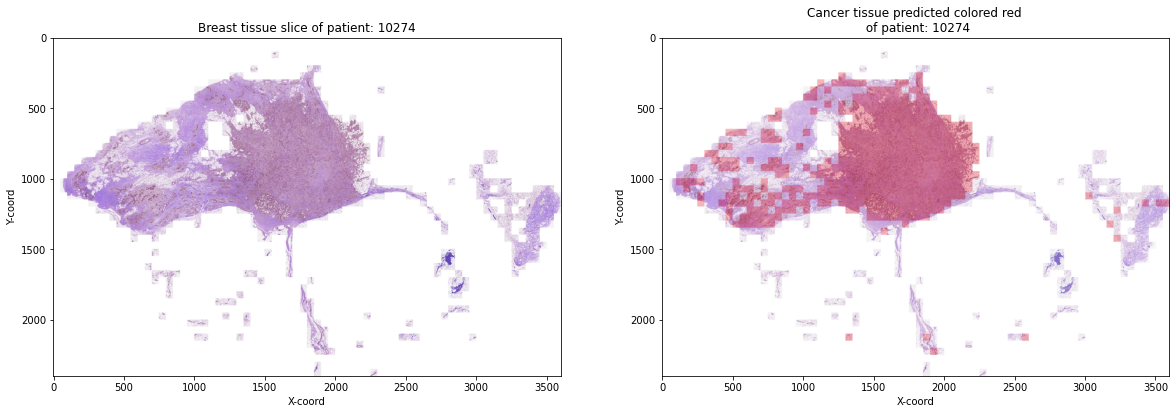

In [ ]:
patient_id = "10274"
model = "experiment5bis_fineTuning_block5_conv2__conv3__conv1.h5"
realty_vs_predict(patient_id,model)

###Experiment 6: two block with experiment2

In [ ]:
vgg16_ft_2_blocks = models.load_model(os.path.join(global_model_path, 'experiment2_dropout.h5'))

for layer in vgg16_ft_2_blocks.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3', 'block5_conv1', 'block4_conv3', 'block4_conv2', 'block4_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg16_ft_2_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg16_ft_2_blocks.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem_2   (None, 50, 50, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 50, 50, 3)        0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328

Epoch 1/15
2955/2955 [==============================] - ETA: 0s - loss: 0.3718 - accuracy: 0.8387
Epoch 1: val_loss improved from inf to 0.34892, saving model to /content/models/experiment6_fineTuning_block5__block4.h5
2955/2955 [==============================] - 119s 39ms/step - loss: 0.3718 - accuracy: 0.8387 - val_loss: 0.3489 - val_accuracy: 0.8472
Epoch 2/15
2955/2955 [==============================] - ETA: 0s - loss: 0.3185 - accuracy: 0.8656
Epoch 2: val_loss did not improve from 0.34892
2955/2955 [==============================] - 132s 45ms/step - loss: 0.3185 - accuracy: 0.8656 - val_loss: 0.3741 - val_accuracy: 0.8356
Epoch 3/15
2955/2955 [==============================] - ETA: 0s - loss: 0.2776 - accuracy: 0.8841
Epoch 3: val_loss did not improve from 0.34892
2955/2955 [==============================] - 114s 38ms/step - loss: 0.2776 - accuracy: 0.8841 - val_loss: 0.3850 - val_accuracy: 0.8354
Epoch 4/15
2955/2955 [==============================] - ETA: 0s - loss: 0.2299 - ac

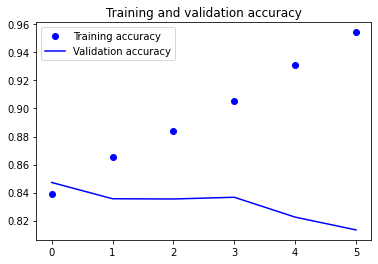

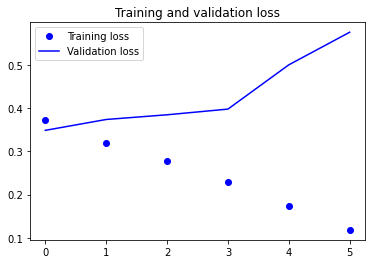

In [ ]:
run_training(vgg16_ft_2_blocks, 'experiment6_fineTuning_block5__block4', num_epochs = 15, patience=5, monitor='val_loss')

1735/1735 [==============================] - 23s 13ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.9218    0.8842    0.9026     39748
           1     0.7352    0.8107    0.7711     15758

    accuracy                         0.8633     55506
   macro avg     0.8285    0.8475    0.8368     55506
weighted avg     0.8688    0.8633    0.8653     55506

Matrice di confusione:
[[35146  4602]
 [ 2983 12775]]
Classification report:
              precision    recall  f1-score   support

           0     0.9218    0.8842    0.9026     39748
           1     0.7352    0.8107    0.7711     15758

    accuracy                         0.8633     55506
   macro avg     0.8285    0.8475    0.8368     55506
weighted avg     0.8688    0.8633    0.8653     55506



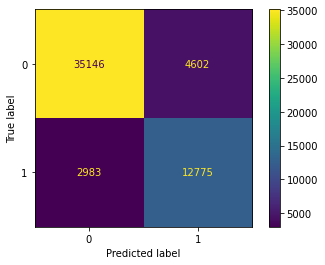

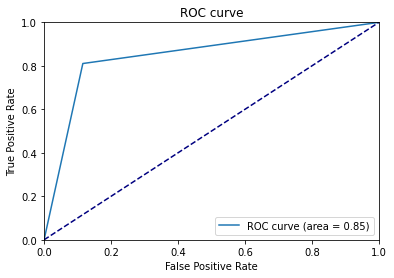

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/experiment6_fineTuning_block5__block4.h5'),"experiment6_fineTuning_block5__block4")

28/28 [==============================] - 1s 15ms/step


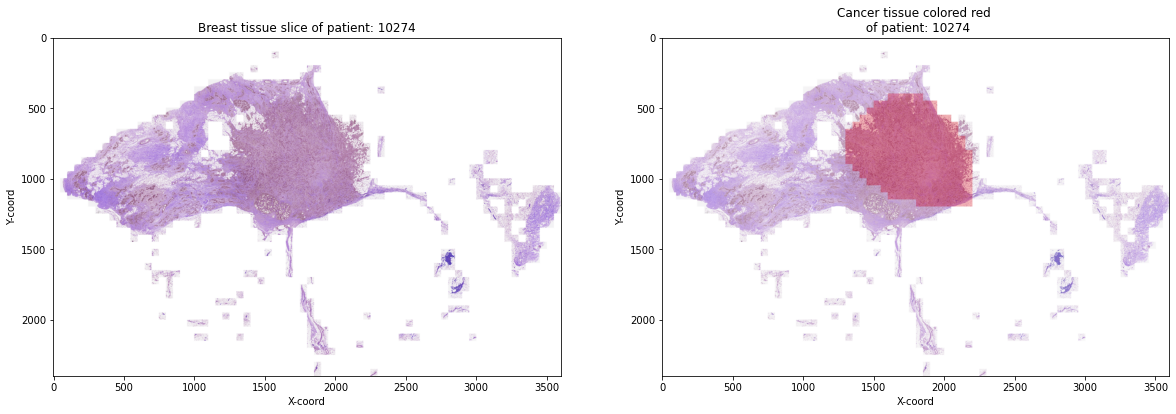

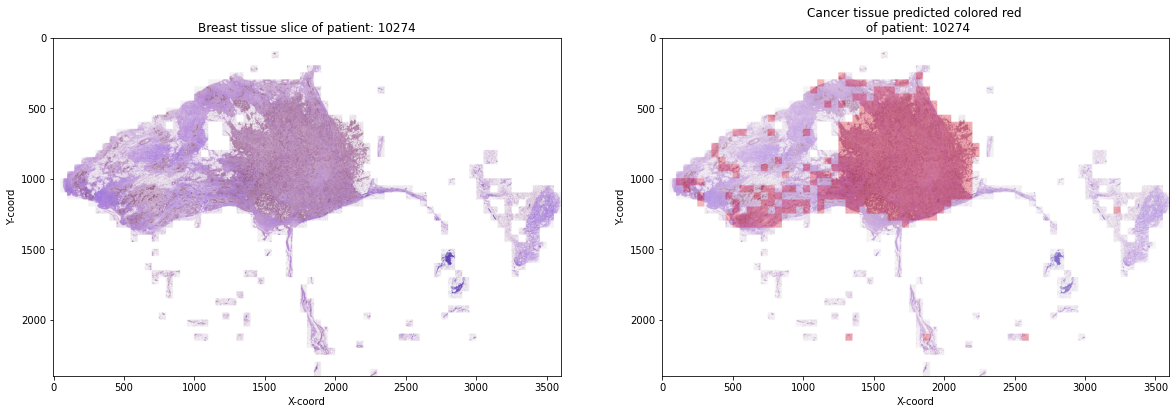

In [ ]:
patient_id = "10274"
model = "experiment6_fineTuning_block5__block4.h5"
realty_vs_predict(patient_id,model)

#Eliminate Block

###Experiment 7: Eliminate "***block5_conv1, block5_conv2,  block5_conv3***" Layers

In [ ]:
model = Sequential()
for layer in conv_base.layers:
  if layer.name in ('block5_conv2', 'block5_conv3', 'block5_conv1'):
    break
  layer.trainable = False
  model.add(layer)

model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       2

In [ ]:
inputs = keras.Input(shape=(50,50,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = model(x)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)
vgg_cut_model = keras.Model(inputs, outputs)
compile_model(vgg_cut_model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem_1   (None, 50, 50, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 50, 50, 3)        0         
 a)                                                              
                                                                 
 sequential (Sequential)     (None, 3, 3, 512)         7635264   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                             

Epoch 1/15
2951/2955 [============================>.] - ETA: 0s - loss: 19.3532 - accuracy: 0.7622
Epoch 1: val_loss improved from inf to 6.24770, saving model to /content/models/experiment7_cut_block5 .h5
2955/2955 [==============================] - 55s 18ms/step - loss: 19.3473 - accuracy: 0.7622 - val_loss: 6.2477 - val_accuracy: 0.8255
Epoch 2/15
2955/2955 [==============================] - ETA: 0s - loss: 8.2932 - accuracy: 0.7827
Epoch 2: val_loss improved from 6.24770 to 3.33677, saving model to /content/models/experiment7_cut_block5 .h5
2955/2955 [==============================] - 54s 18ms/step - loss: 8.2932 - accuracy: 0.7827 - val_loss: 3.3368 - val_accuracy: 0.7927
Epoch 3/15
2955/2955 [==============================] - ETA: 0s - loss: 2.5927 - accuracy: 0.7840
Epoch 3: val_loss improved from 3.33677 to 0.51076, saving model to /content/models/experiment7_cut_block5 .h5
2955/2955 [==============================] - 54s 18ms/step - loss: 2.5927 - accuracy: 0.7840 - val_loss: 

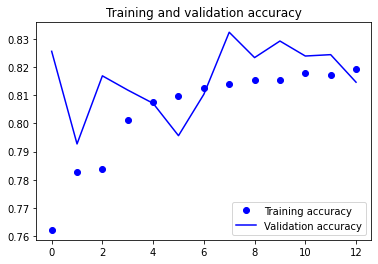

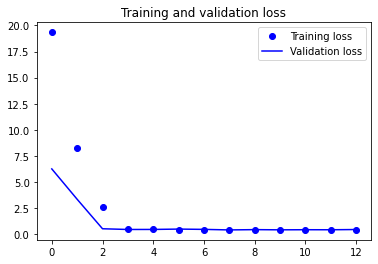

In [ ]:
run_training(vgg_cut_model, 'experiment7_cut_block5 ', num_epochs = 15, patience=5, monitor='val_loss')

1735/1735 [==============================] - 17s 10ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.8983    0.8869    0.8925     39748
           1     0.7235    0.7466    0.7349     15758

    accuracy                         0.8470     55506
   macro avg     0.8109    0.8167    0.8137     55506
weighted avg     0.8486    0.8470    0.8478     55506

Matrice di confusione:
[[35251  4497]
 [ 3993 11765]]
Classification report:
              precision    recall  f1-score   support

           0     0.8983    0.8869    0.8925     39748
           1     0.7235    0.7466    0.7349     15758

    accuracy                         0.8470     55506
   macro avg     0.8109    0.8167    0.8137     55506
weighted avg     0.8486    0.8470    0.8478     55506



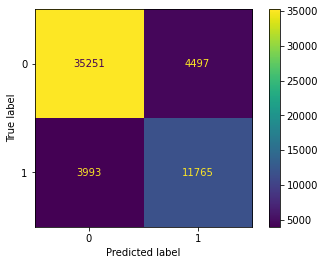

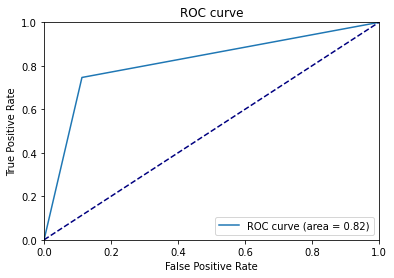

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/experiment7_cut_block5 .h5'),"experiment7_cut_block5") 

28/28 [==============================] - 0s 10ms/step


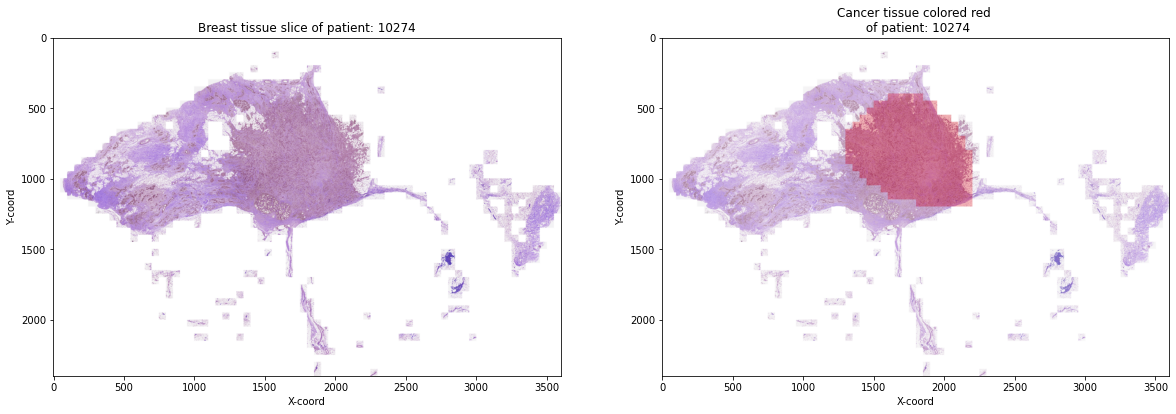

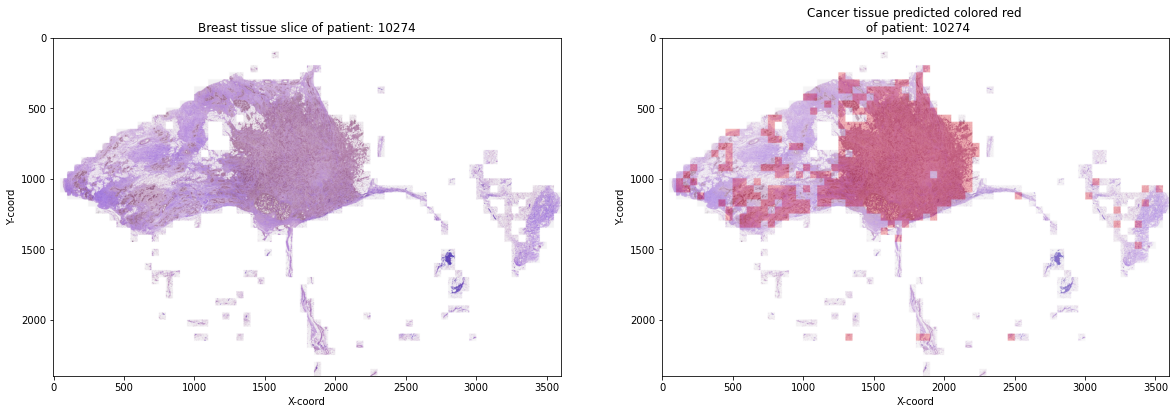

In [ ]:
patient_id = "10274"
model = "experiment7_cut_block5 .h5"
realty_vs_predict(patient_id,model)

# Fine Tuning in model with removal

#Experiment 8: block4

In [ ]:
vgg16_remove_blocks = models.load_model(os.path.join(global_model_path, 'experiment7_cut_block5 .h5'))

for layer in vgg16_remove_blocks.get_layer('sequential').layers:
    if layer.name in ('block4_conv3', 'block4_conv2', 'block4_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg16_remove_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg16_remove_blocks.get_layer('sequential').layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem_1   (None, 50, 50, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 50, 50, 3)        0         
 a)                                                              
                                                                 
 sequential (Sequential)     (None, 3, 3, 512)         7635264   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                             

Epoch 1/15
2953/2955 [============================>.] - ETA: 0s - loss: 0.3553 - accuracy: 0.8474
Epoch 1: val_loss improved from inf to 0.35245, saving model to /content/models/experiment8_FT_block4.h5
2955/2955 [==============================] - 77s 26ms/step - loss: 0.3553 - accuracy: 0.8474 - val_loss: 0.3525 - val_accuracy: 0.8491
Epoch 2/15
2953/2955 [============================>.] - ETA: 0s - loss: 0.3233 - accuracy: 0.8627
Epoch 2: val_loss did not improve from 0.35245
2955/2955 [==============================] - 79s 27ms/step - loss: 0.3233 - accuracy: 0.8627 - val_loss: 0.3824 - val_accuracy: 0.8371
Epoch 3/15
2954/2955 [============================>.] - ETA: 0s - loss: 0.2944 - accuracy: 0.8772
Epoch 3: val_loss did not improve from 0.35245
2955/2955 [==============================] - 75s 25ms/step - loss: 0.2944 - accuracy: 0.8773 - val_loss: 0.3676 - val_accuracy: 0.8428
Epoch 4/15
2953/2955 [============================>.] - ETA: 0s - loss: 0.2597 - accuracy: 0.8931
Epoc

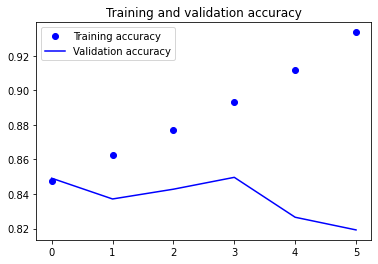

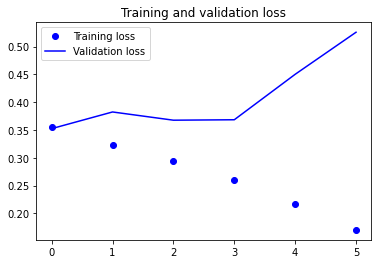

In [ ]:
run_training(vgg16_remove_blocks, 'experiment8_FT_block4', num_epochs = 15, patience=5, monitor='val_loss')

1735/1735 [==============================] - 17s 9ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.9235    0.8799    0.9012     39748
           1     0.7293    0.8161    0.7703     15758

    accuracy                         0.8618     55506
   macro avg     0.8264    0.8480    0.8357     55506
weighted avg     0.8684    0.8618    0.8640     55506

Matrice di confusione:
[[34975  4773]
 [ 2898 12860]]
Classification report:
              precision    recall  f1-score   support

           0     0.9235    0.8799    0.9012     39748
           1     0.7293    0.8161    0.7703     15758

    accuracy                         0.8618     55506
   macro avg     0.8264    0.8480    0.8357     55506
weighted avg     0.8684    0.8618    0.8640     55506



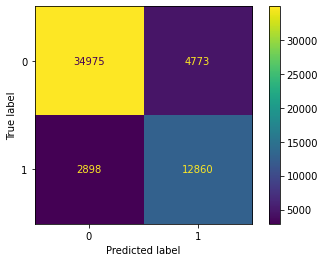

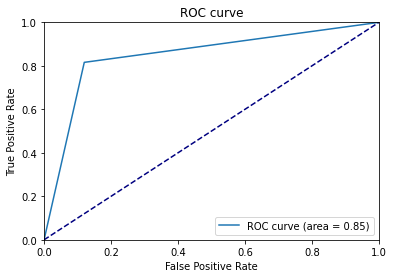

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/experiment8_FT_block4.h5'),"experiment8_FT_block4")

28/28 [==============================] - 0s 11ms/step


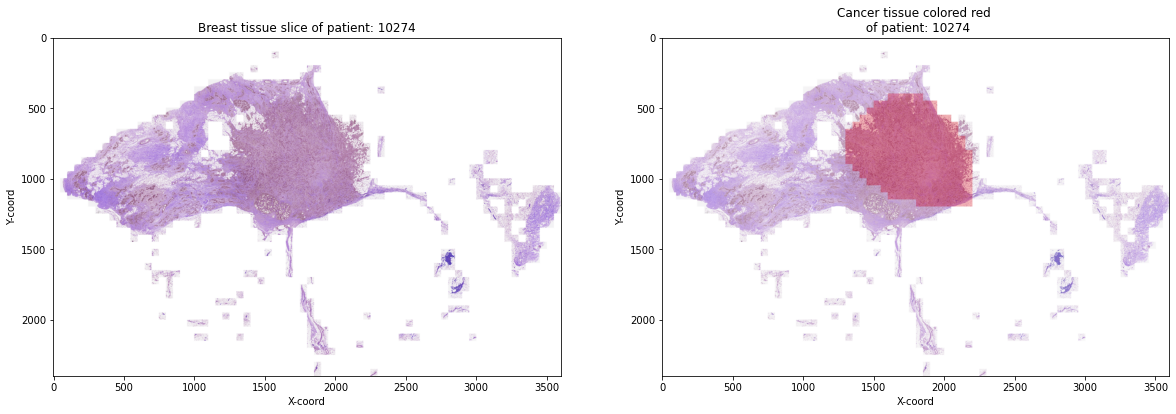

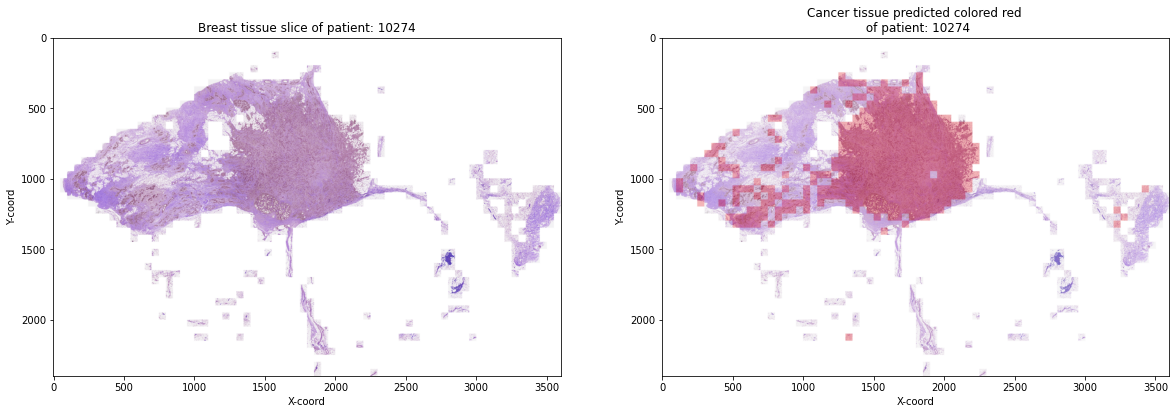

In [ ]:
patient_id = "10274"
model = "experiment8_FT_block4.h5"
realty_vs_predict(patient_id,model)

In [ ]:
!pip install opencv-python

# CLAHE

In [8]:
# Create two empty arrays to store the processed images and their labels
non_img_arr = []
can_img_arr = []

# Crea un'istanza di CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# Loop through the list of file names in N_IDC
for img in N_IDC:
    
    # Read the image using OpenCV's imread function
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    
    # Split the image into its individual color channels
    b, g, r = cv2.split(n_img)
    
    # Apply CLAHE to each color channel
    b = clahe.apply(b)
    g = clahe.apply(g)
    r = clahe.apply(r)
    
    # Merge the CLAHE-processed color channels back into an RGB image
    n_img = cv2.merge((b, g, r))

    # Resize the image to 50x50 using OpenCV's resize function
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    
    # Add the resized image and label (0) to the non_img_arr list
    non_img_arr.append([n_img_size, 0])
    
# Loop through the list of file names in P_IDC
for img in P_IDC:
    # Read the image using OpenCV's imread function
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    
    # Split the image into its individual color channels
    b, g, r = cv2.split(c_img)
    
    # Apply CLAHE to each color channel
    b = clahe.apply(b)
    g = clahe.apply(g)
    r = clahe.apply(r)
    
    # Merge the CLAHE-processed color channels back into an RGB image
    c_img = cv2.merge((b, g, r))

    # Resize the image to 50x50 using OpenCV's resize function
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    
    # Add the resized image and label (1) to the can_img_arr list
    can_img_arr.append([c_img_size, 1])

In [16]:
print(f"negative: {len(non_img_arr)} with perc: {(1-len(can_img_arr)/len(non_img_arr))*100}%, positive: {len(can_img_arr)} with perc: {(len(can_img_arr)/len(non_img_arr))*100}%")
length = int(len(non_img_arr))
train_non_img_arr = non_img_arr[:int(0.6 * length)]
validation_non_img_arr = non_img_arr[int(0.6 * length): int(0.8 * length)]
test_non_img_arr = non_img_arr[int(0.8 * length):int(length)]
print(f"len of train_negative: {len(train_non_img_arr)}, len of validation_negative: {len(validation_non_img_arr)}, len of test_negative: {len(test_non_img_arr)} ")

length = int(len(can_img_arr))
train_can_img_arr = can_img_arr[:int(0.6 * length)]
validation_can_img_arr = can_img_arr[int(0.6 * length): int(0.8 * length)]
test_can_img_arr = can_img_arr[int(0.8 * length):int(length)]
print(f"len of train_positive: {len(train_can_img_arr)}, len of validation_positive: {len(validation_can_img_arr)}, len of test_positive: {len(test_can_img_arr)} ")

length = len(train_can_img_arr)
random.shuffle(train_non_img_arr)
train_non_img_arr = train_non_img_arr[:int(length)]
print(f"new len of train_negative {len(train_non_img_arr)}. Now, the len of postive and negative sample is same")


train = np.concatenate((train_non_img_arr,train_can_img_arr))
validation = np.concatenate((validation_non_img_arr,validation_can_img_arr))
test = np.concatenate((test_non_img_arr,test_can_img_arr))

train_idx = np.random.permutation(train.shape[0])
train = train[train_idx]

validation_idx = np.random.permutation(validation.shape[0])
validation = validation[validation_idx]

test_idx = np.random.permutation(test.shape[0])
test = test[test_idx]

negative: 198738 with perc: 60.35685173444434%, positive: 78786 with perc: 39.64314826555565%
len of train_negative: 119242, len of validation_negative: 39748, len of test_negative: 39748 
len of train_positive: 47271, len of validation_positive: 15757, len of test_positive: 15758 
new len of train_negative 47271. Now, the len of postive and negative sample is same


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [17]:
X_train = []
X_test = []
X_val = []
Y_train = []
Y_test = [] 
Y_val = []


for feature, label in train:
    X_train.append(feature)
    Y_train.append(label)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

for feature, label in validation:
    X_val.append(feature)
    Y_val.append(label)
X_val = np.array(X_val)
Y_val = np.array(Y_val)

for feature, label in test:
    X_test.append(feature)
    Y_test.append(label)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [18]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
Y_val = to_categorical(Y_val, num_classes = 2)


print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (94542, 50, 50, 3)
Validation Data Shape: (55505, 50, 50, 3)
Testing Data Shape: (55506, 50, 50, 3)


In [19]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(50,50,3)
)

In [20]:
from tensorflow.keras import layers
import tensorflow as tf

model = Sequential()
for layer in conv_base.layers:
  if layer.name in ('block5_conv2', 'block5_conv3', 'block5_conv1'):
    break
  layer.trainable = False
  model.add(layer)

model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       2

In [ ]:
inputs = keras.Input(shape=(50,50,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = model(x)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)
vgg_cut_model = keras.Model(inputs, outputs)
compile_model(vgg_cut_model)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem_1   (None, 50, 50, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 50, 50, 3)        0         
 a)                                                              
                                                                 
 sequential_1 (Sequential)   (None, 3, 3, 512)         7635264   
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/15
2955/2955 [==============================] - ETA: 0s - loss: 21.0633 - accuracy: 0.7673
Epoch 1: val_loss improved from inf to 7.40014, saving model to /content/models/firstPhase_CLAHE.h5
2955/2955 [==============================] - 58s 19ms/step - loss: 21.0633 - accuracy: 0.7673 - val_loss: 7.4001 - val_accuracy: 0.8129
Epoch 2/15
2951/2955 [============================>.] - ETA: 0s - loss: 8.7011 - accuracy: 0.7893
Epoch 2: val_loss improved from 7.40014 to 2.83467, saving model to /content/models/firstPhase_CLAHE.h5
2955/2955 [==============================] - 52s 17ms/step - loss: 8.6957 - accuracy: 0.7894 - val_loss: 2.8347 - val_accuracy: 0.8250
Epoch 3/15
2953/2955 [============================>.] - ETA: 0s - loss: 2.4446 - accuracy: 0.7948
Epoch 3: val_loss improved from 2.83467 to 0.41397, saving model to /content/models/firstPhase_CLAHE.h5
2955/2955 [==============================] - 55s 18ms/step - loss: 2.4436 - accuracy: 0.7948 - val_loss: 0.4140 - val_accuracy

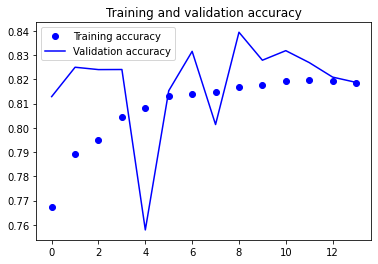

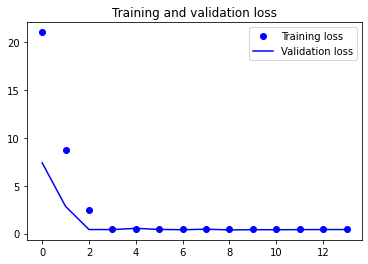

In [ ]:
run_training(vgg_cut_model, 'firstPhase_CLAHE', num_epochs = 15, patience=5, monitor='val_loss')

At equal levels with clahe the accuracy has improved

1735/1735 [==============================] - 17s 10ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.8882    0.9090    0.8985     39748
           1     0.7560    0.7113    0.7330     15758

    accuracy                         0.8529     55506
   macro avg     0.8221    0.8101    0.8157     55506
weighted avg     0.8506    0.8529    0.8515     55506

Matrice di confusione:
[[36130  3618]
 [ 4549 11209]]
Classification report:
              precision    recall  f1-score   support

           0     0.8882    0.9090    0.8985     39748
           1     0.7560    0.7113    0.7330     15758

    accuracy                         0.8529     55506
   macro avg     0.8221    0.8101    0.8157     55506
weighted avg     0.8506    0.8529    0.8515     55506



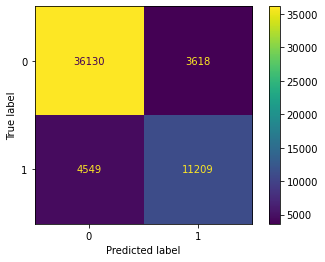

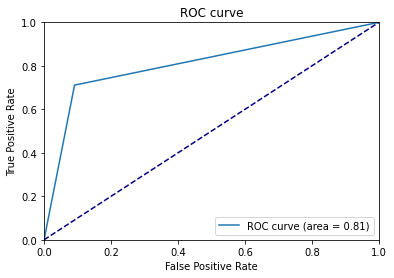

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/firstPhase_CLAHE.h5'),"firstPhase_CLAHE")

In [ ]:
#second model phase
vgg16_remove_blocks = models.load_model(os.path.join(global_model_path, 'firstPhase_CLAHE.h5'))

for layer in vgg16_remove_blocks.get_layer('sequential_1').layers:
    if layer.name in ('block4_conv3', 'block4_conv2', 'block4_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg16_remove_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg16_remove_blocks.get_layer('sequential_1').layers):
    print(i, layer.name, layer.trainable)




Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem_3   (None, 50, 50, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 50, 50, 3)        0         
 a)                                                              
                                                                 
 sequential_1 (Sequential)   (None, 3, 3, 512)         7635264   
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/15
2955/2955 [==============================] - ETA: 0s - loss: 0.3802 - accuracy: 0.8381
Epoch 1: val_loss improved from inf to 0.40982, saving model to /content/models/secondPhase_CLAHE.h5
2955/2955 [==============================] - 89s 26ms/step - loss: 0.3802 - accuracy: 0.8381 - val_loss: 0.4098 - val_accuracy: 0.8222
Epoch 2/15
2954/2955 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8560
Epoch 2: val_loss improved from 0.40982 to 0.36327, saving model to /content/models/secondPhase_CLAHE.h5
2955/2955 [==============================] - 79s 27ms/step - loss: 0.3412 - accuracy: 0.8560 - val_loss: 0.3633 - val_accuracy: 0.8420
Epoch 3/15
2955/2955 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.8687
Epoch 3: val_loss did not improve from 0.36327
2955/2955 [==============================] - 79s 27ms/step - loss: 0.3139 - accuracy: 0.8687 - val_loss: 0.3923 - val_accuracy: 0.8342
Epoch 4/15
2954/2955 [==========================

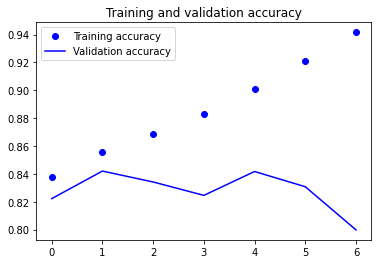

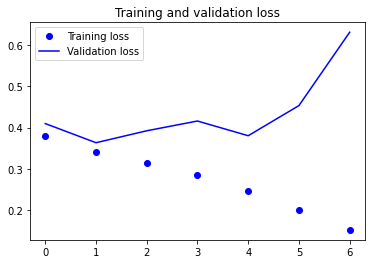

In [ ]:
run_training(vgg16_remove_blocks, 'secondPhase_CLAHE', num_epochs = 15, patience=5, monitor='val_loss')

1735/1735 [==============================] - 17s 10ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.9295    0.8729    0.9003     39748
           1     0.7221    0.8331    0.7736     15758

    accuracy                         0.8616     55506
   macro avg     0.8258    0.8530    0.8370     55506
weighted avg     0.8706    0.8616    0.8643     55506

Matrice di confusione:
[[34695  5053]
 [ 2630 13128]]
Classification report:
              precision    recall  f1-score   support

           0     0.9295    0.8729    0.9003     39748
           1     0.7221    0.8331    0.7736     15758

    accuracy                         0.8616     55506
   macro avg     0.8258    0.8530    0.8370     55506
weighted avg     0.8706    0.8616    0.8643     55506



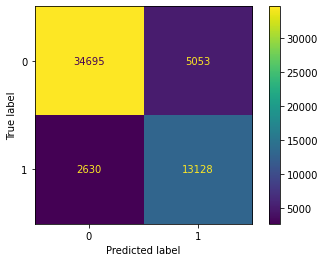

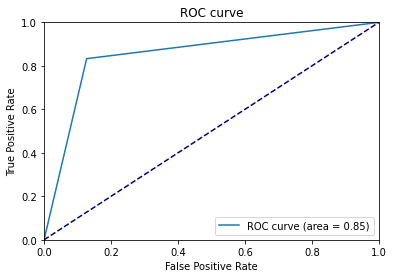

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/secondPhase_CLAHE.h5'),"secondPhase_CLAHE")

In [ ]:
#third model phase
vgg16_remove_blocks = models.load_model(os.path.join(global_model_path, 'secondPhase_CLAHE.h5'))

for layer in vgg16_remove_blocks.get_layer('sequential_1').layers:
    if layer.name in ('block3_conv3', 'block3_conv2', 'block3_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg16_remove_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg16_remove_blocks.get_layer('sequential_1').layers):
    print(i, layer.name, layer.trainable)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem_3   (None, 50, 50, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 50, 50, 3)        0         
 a)                                                              
                                                                 
 sequential_1 (Sequential)   (None, 3, 3, 512)         7635264   
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/15
2955/2955 [==============================] - ETA: 0s - loss: 0.3050 - accuracy: 0.8731
Epoch 1: val_loss improved from inf to 0.40511, saving model to /content/models/thirdPhase_CLAHE.h5
2955/2955 [==============================] - 76s 25ms/step - loss: 0.3050 - accuracy: 0.8731 - val_loss: 0.4051 - val_accuracy: 0.8266
Epoch 2/15
2954/2955 [============================>.] - ETA: 0s - loss: 0.2904 - accuracy: 0.8802
Epoch 2: val_loss improved from 0.40511 to 0.37681, saving model to /content/models/thirdPhase_CLAHE.h5
2955/2955 [==============================] - 75s 25ms/step - loss: 0.2904 - accuracy: 0.8802 - val_loss: 0.3768 - val_accuracy: 0.8361
Epoch 3/15
2953/2955 [============================>.] - ETA: 0s - loss: 0.2905 - accuracy: 0.8796
Epoch 3: val_loss did not improve from 0.37681
2955/2955 [==============================] - 75s 25ms/step - loss: 0.2905 - accuracy: 0.8796 - val_loss: 0.4029 - val_accuracy: 0.8301
Epoch 4/15
2953/2955 [============================

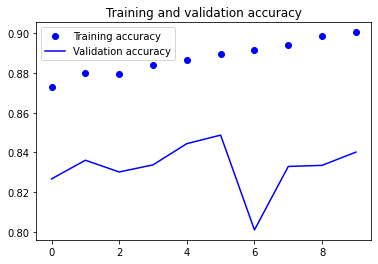

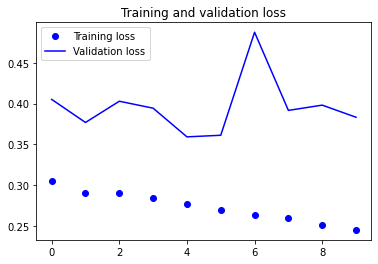

In [ ]:
run_training(vgg16_remove_blocks, 'thirdPhase_CLAHE', num_epochs = 15, patience=5, monitor='val_loss')

1735/1735 [==============================] - 17s 9ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.9308    0.8778    0.9035     39748
           1     0.7304    0.8353    0.7793     15758

    accuracy                         0.8657     55506
   macro avg     0.8306    0.8565    0.8414     55506
weighted avg     0.8739    0.8657    0.8682     55506

Matrice di confusione:
[[34889  4859]
 [ 2595 13163]]
Classification report:
              precision    recall  f1-score   support

           0     0.9308    0.8778    0.9035     39748
           1     0.7304    0.8353    0.7793     15758

    accuracy                         0.8657     55506
   macro avg     0.8306    0.8565    0.8414     55506
weighted avg     0.8739    0.8657    0.8682     55506



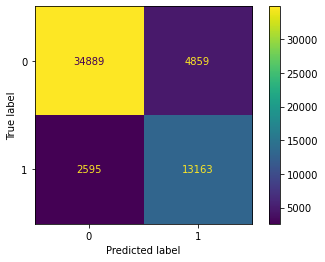

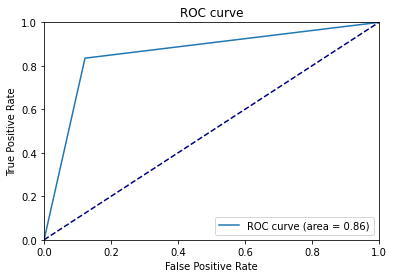

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/thirdPhase_CLAHE.h5'),"thirdPhase_CLAHE")

In [ ]:
#fourth model phase
vgg16_remove_blocks = models.load_model(os.path.join(global_model_path, 'thirdPhase_CLAHE.h5'))

for layer in vgg16_remove_blocks.get_layer('sequential_1').layers:
    if layer.name in ('block2_conv3', 'block2_conv2', 'block2_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg16_remove_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg16_remove_blocks.get_layer('sequential_1').layers):
    print(i, layer.name, layer.trainable)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem_3   (None, 50, 50, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 50, 50, 3)        0         
 a)                                                              
                                                                 
 sequential_1 (Sequential)   (None, 3, 3, 512)         7635264   
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/15
2955/2955 [==============================] - ETA: 0s - loss: 0.2555 - accuracy: 0.8962
Epoch 1: val_loss improved from inf to 0.39002, saving model to /content/models/fourthPhase_CLAHE.h5
2955/2955 [==============================] - 81s 27ms/step - loss: 0.2555 - accuracy: 0.8962 - val_loss: 0.3900 - val_accuracy: 0.8377
Epoch 2/15
2953/2955 [============================>.] - ETA: 0s - loss: 0.2508 - accuracy: 0.8988
Epoch 2: val_loss improved from 0.39002 to 0.38176, saving model to /content/models/fourthPhase_CLAHE.h5
2955/2955 [==============================] - 77s 26ms/step - loss: 0.2508 - accuracy: 0.8988 - val_loss: 0.3818 - val_accuracy: 0.8436
Epoch 3/15
2954/2955 [============================>.] - ETA: 0s - loss: 0.2575 - accuracy: 0.8954
Epoch 3: val_loss did not improve from 0.38176
2955/2955 [==============================] - 80s 27ms/step - loss: 0.2575 - accuracy: 0.8954 - val_loss: 0.4254 - val_accuracy: 0.8253
Epoch 4/15
2955/2955 [==========================

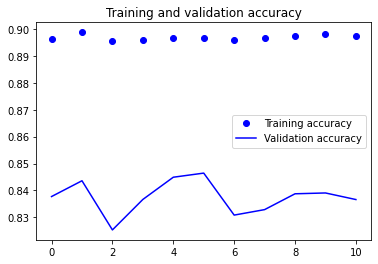

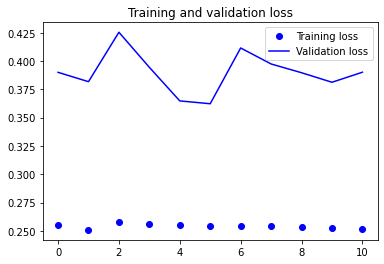

In [ ]:
run_training(vgg16_remove_blocks, 'fourthPhase_CLAHE', num_epochs = 15, patience=5, monitor='val_loss')

1735/1735 [==============================] - 17s 10ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.9260    0.8861    0.9056     39748
           1     0.7408    0.8214    0.7790     15758

    accuracy                         0.8677     55506
   macro avg     0.8334    0.8537    0.8423     55506
weighted avg     0.8734    0.8677    0.8697     55506

Matrice di confusione:
[[35219  4529]
 [ 2814 12944]]
Classification report:
              precision    recall  f1-score   support

           0     0.9260    0.8861    0.9056     39748
           1     0.7408    0.8214    0.7790     15758

    accuracy                         0.8677     55506
   macro avg     0.8334    0.8537    0.8423     55506
weighted avg     0.8734    0.8677    0.8697     55506



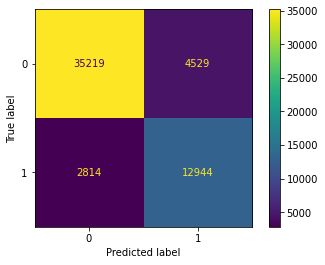

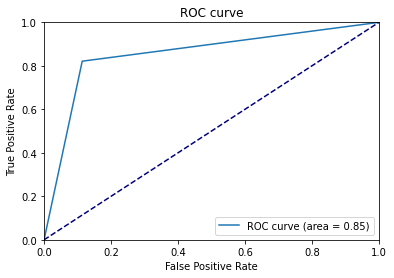

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/fourthPhase_CLAHE.h5'),"fourthPhase_CLAHE")

In [ ]:
#fifth model phase
vgg16_remove_blocks = models.load_model(os.path.join(global_model_path, 'fourthPhase_CLAHE.h5'))

for layer in vgg16_remove_blocks.get_layer('sequential_1').layers:
    if layer.name in ('block1_conv3', 'block1_conv2', 'block1_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg16_remove_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg16_remove_blocks.get_layer('sequential_1').layers):
    print(i, layer.name, layer.trainable)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem_3   (None, 50, 50, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 50, 50, 3)        0         
 a)                                                              
                                                                 
 sequential_1 (Sequential)   (None, 3, 3, 512)         7635264   
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/15
2955/2955 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.8880
Epoch 1: val_loss improved from inf to 0.35675, saving model to /content/models/fifthPhase_CLAHE.h5
2955/2955 [==============================] - 101s 30ms/step - loss: 0.2737 - accuracy: 0.8880 - val_loss: 0.3568 - val_accuracy: 0.8480
Epoch 2/15
2954/2955 [============================>.] - ETA: 0s - loss: 0.2725 - accuracy: 0.8883
Epoch 2: val_loss did not improve from 0.35675
2955/2955 [==============================] - 90s 30ms/step - loss: 0.2725 - accuracy: 0.8883 - val_loss: 0.3577 - val_accuracy: 0.8476
Epoch 3/15
2953/2955 [============================>.] - ETA: 0s - loss: 0.2719 - accuracy: 0.8891
Epoch 3: val_loss did not improve from 0.35675
2955/2955 [==============================] - 90s 30ms/step - loss: 0.2719 - accuracy: 0.8891 - val_loss: 0.3575 - val_accuracy: 0.8477
Epoch 4/15
2954/2955 [============================>.] - ETA: 0s - loss: 0.2711 - accuracy: 0.8896
Epoch 4:

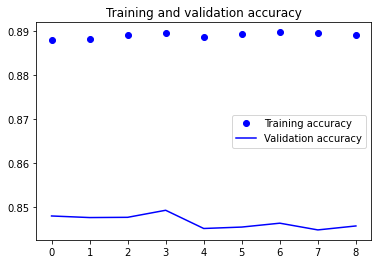

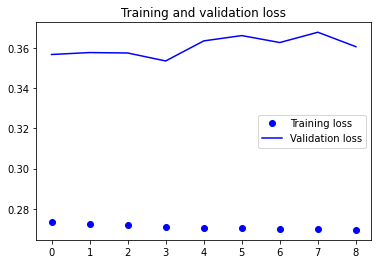

In [ ]:
run_training(vgg16_remove_blocks, 'fifthPhase_CLAHE', num_epochs = 15, patience=5, monitor='val_loss')

1735/1735 [==============================] - 17s 10ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.9269    0.8892    0.9077     39748
           1     0.7466    0.8232    0.7830     15758

    accuracy                         0.8705     55506
   macro avg     0.8368    0.8562    0.8454     55506
weighted avg     0.8757    0.8705    0.8723     55506

Matrice di confusione:
[[35345  4403]
 [ 2786 12972]]
Classification report:
              precision    recall  f1-score   support

           0     0.9269    0.8892    0.9077     39748
           1     0.7466    0.8232    0.7830     15758

    accuracy                         0.8705     55506
   macro avg     0.8368    0.8562    0.8454     55506
weighted avg     0.8757    0.8705    0.8723     55506



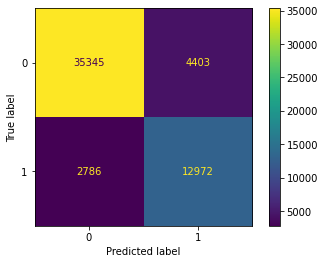

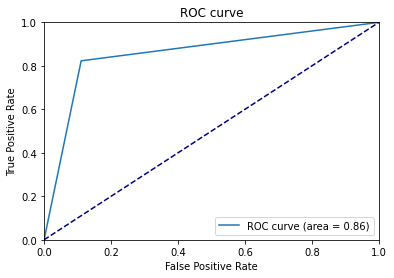

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/fifthPhase_CLAHE.h5'),"fifthPhase_CLAHE")

In [ ]:
#sixth model phase
vgg16_remove_blocks = models.load_model(os.path.join(global_model_path, 'fifthPhase_CLAHE.h5'))

for layer in vgg16_remove_blocks.get_layer('sequential_1').layers:
        layer.trainable = True
   

compile_model(vgg16_remove_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg16_remove_blocks.get_layer('sequential_1').layers):
    print(i, layer.name, layer.trainable)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem_3   (None, 50, 50, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 50, 50, 3)        0         
 a)                                                              
                                                                 
 sequential_1 (Sequential)   (None, 3, 3, 512)         7635264   
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/15
2955/2955 [==============================] - ETA: 0s - loss: 0.2992 - accuracy: 0.8749
Epoch 1: val_loss improved from inf to 0.35476, saving model to /content/models/sixthPhase_CLAHE.h5
2955/2955 [==============================] - 122s 40ms/step - loss: 0.2992 - accuracy: 0.8749 - val_loss: 0.3548 - val_accuracy: 0.8489
Epoch 2/15
2955/2955 [==============================] - ETA: 0s - loss: 0.2721 - accuracy: 0.8883
Epoch 2: val_loss improved from 0.35476 to 0.34351, saving model to /content/models/sixthPhase_CLAHE.h5
2955/2955 [==============================] - 120s 41ms/step - loss: 0.2721 - accuracy: 0.8883 - val_loss: 0.3435 - val_accuracy: 0.8528
Epoch 3/15
2955/2955 [==============================] - ETA: 0s - loss: 0.2360 - accuracy: 0.9043
Epoch 3: val_loss did not improve from 0.34351
2955/2955 [==============================] - 120s 41ms/step - loss: 0.2360 - accuracy: 0.9043 - val_loss: 0.3758 - val_accuracy: 0.8483
Epoch 4/15
2955/2955 [=========================

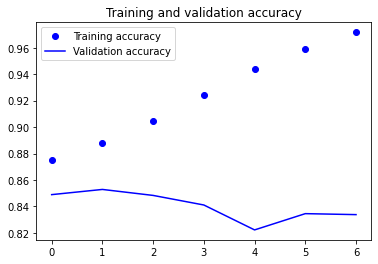

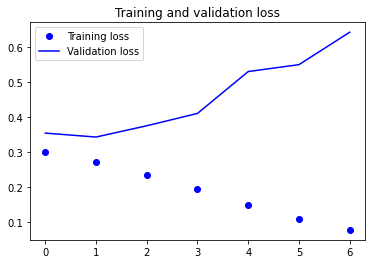

In [ ]:
run_training(vgg16_remove_blocks, 'sixthPhase_CLAHE', num_epochs = 15, patience=5, monitor='val_loss')

1735/1735 [==============================] - 17s 10ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.9224    0.8987    0.9104     39748
           1     0.7601    0.8093    0.7839     15758

    accuracy                         0.8733     55506
   macro avg     0.8412    0.8540    0.8472     55506
weighted avg     0.8763    0.8733    0.8745     55506

Matrice di confusione:
[[35722  4026]
 [ 3005 12753]]
Classification report:
              precision    recall  f1-score   support

           0     0.9224    0.8987    0.9104     39748
           1     0.7601    0.8093    0.7839     15758

    accuracy                         0.8733     55506
   macro avg     0.8412    0.8540    0.8472     55506
weighted avg     0.8763    0.8733    0.8745     55506



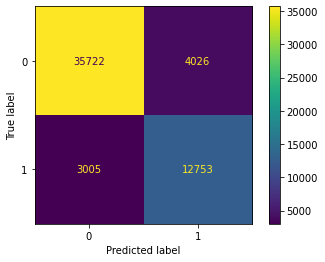

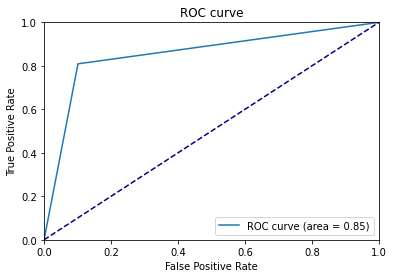

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/sixthPhase_CLAHE.h5'),"sixthPhase_CLAHE")

ciao
28/28 [==============================] - 0s 11ms/step


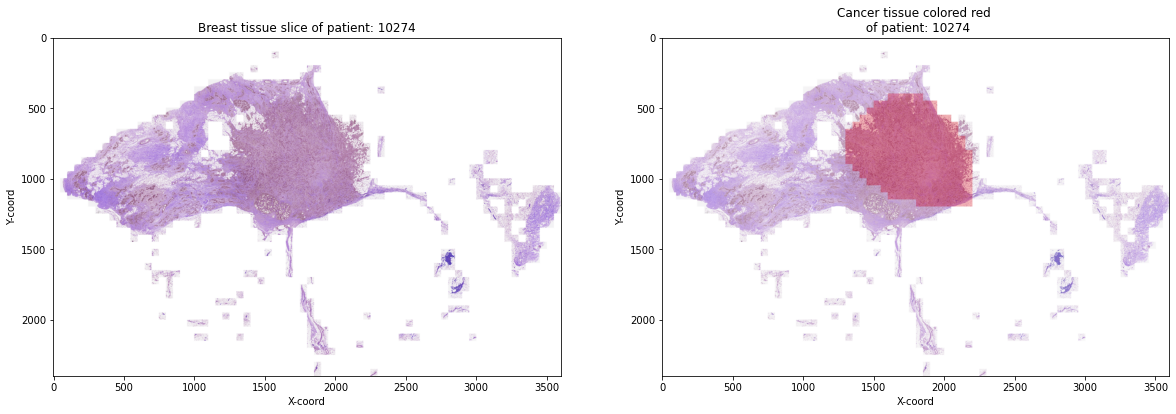

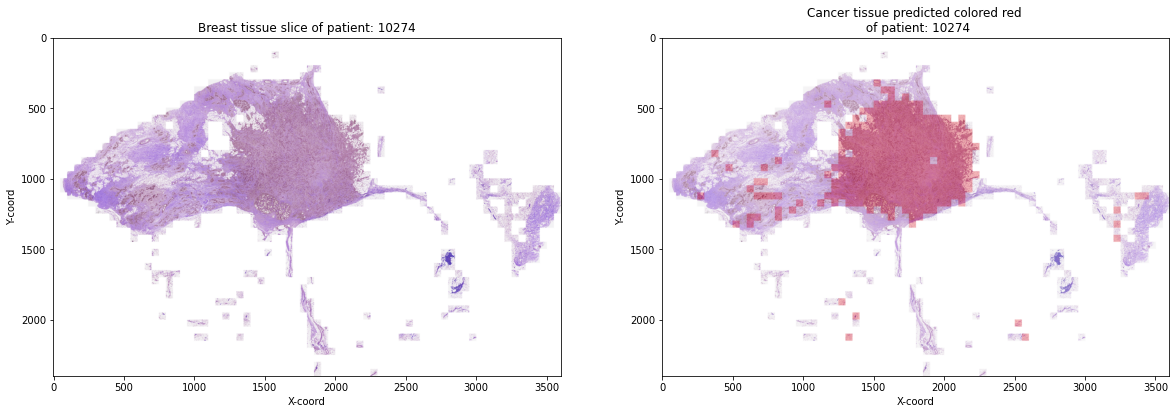

In [ ]:
patient_id = "10274"
model = "sixthPhase_CLAHE.h5"
realty_vs_predict(patient_id,model,"CLAHE")

In [21]:
from tensorflow.keras import layers
import tensorflow as tf

model = Sequential()
for layer in conv_base.layers:
  if layer.name in ('block5_conv2', 'block5_conv3', 'block5_conv1'):
    break
  layer.trainable = True
  model.add(layer)

model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)      

In [22]:
inputs = keras.Input(shape=(50,50,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = model(x)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)
vgg_cut_model = keras.Model(inputs, outputs)
compile_model(vgg_cut_model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 50, 50, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 50, 50, 3)        0         
                                                                 
 sequential_1 (Sequential)   (None, 3, 3, 512)         7635264   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328

Epoch 1/15
2955/2955 [==============================] - ETA: 0s - loss: 0.6498 - accuracy: 0.8134
Epoch 1: val_loss improved from inf to 0.32891, saving model to /content/models/AllLevelsUnlocked_CLAHE.h5
2955/2955 [==============================] - 129s 38ms/step - loss: 0.6498 - accuracy: 0.8134 - val_loss: 0.3289 - val_accuracy: 0.8620
Epoch 2/15
2955/2955 [==============================] - ETA: 0s - loss: 0.3676 - accuracy: 0.8434
Epoch 2: val_loss did not improve from 0.32891
2955/2955 [==============================] - 113s 38ms/step - loss: 0.3676 - accuracy: 0.8434 - val_loss: 0.3934 - val_accuracy: 0.8408
Epoch 3/15
2955/2955 [==============================] - ETA: 0s - loss: 0.3439 - accuracy: 0.8550
Epoch 3: val_loss did not improve from 0.32891
2955/2955 [==============================] - 110s 37ms/step - loss: 0.3439 - accuracy: 0.8550 - val_loss: 0.3410 - val_accuracy: 0.8503
Epoch 4/15
2955/2955 [==============================] - ETA: 0s - loss: 0.3225 - accuracy: 0.8651

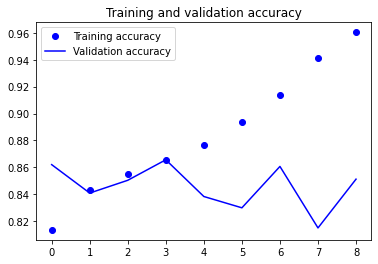

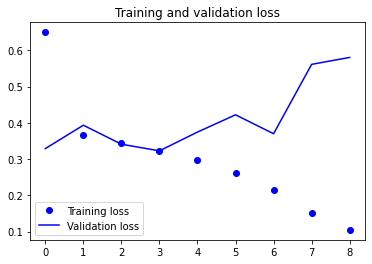

In [25]:
run_training(vgg_cut_model, 'AllLevelsUnlocked_CLAHE', num_epochs = 15, patience=5, monitor='val_loss')

1735/1735 [==============================] - 16s 9ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.9401    0.8689    0.9031     39748
           1     0.7225    0.8605    0.7854     15758

    accuracy                         0.8665     55506
   macro avg     0.8313    0.8647    0.8443     55506
weighted avg     0.8783    0.8665    0.8697     55506

Matrice di confusione:
[[34539  5209]
 [ 2199 13559]]
Classification report:
              precision    recall  f1-score   support

           0     0.9401    0.8689    0.9031     39748
           1     0.7225    0.8605    0.7854     15758

    accuracy                         0.8665     55506
   macro avg     0.8313    0.8647    0.8443     55506
weighted avg     0.8783    0.8665    0.8697     55506



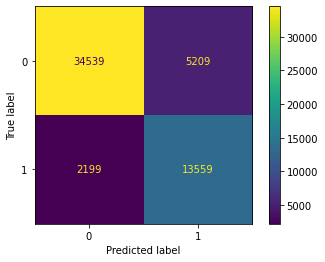

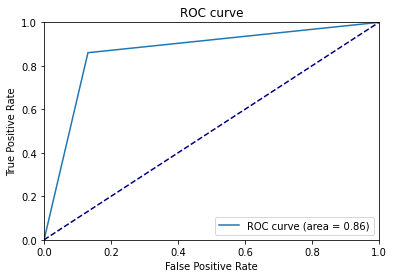

In [26]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/AllLevelsUnlocked_CLAHE.h5'),"AllLevelsUnlocked_CLAHE")

ciao
28/28 [==============================] - 0s 10ms/step


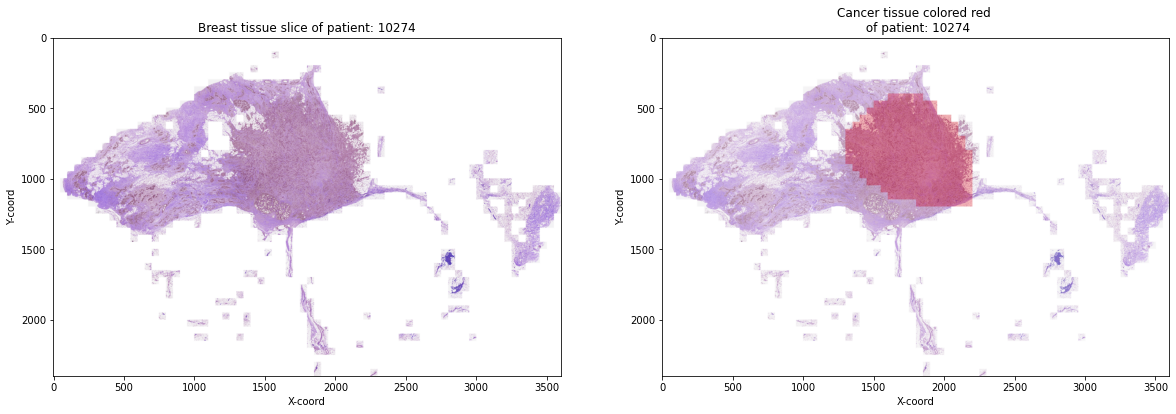

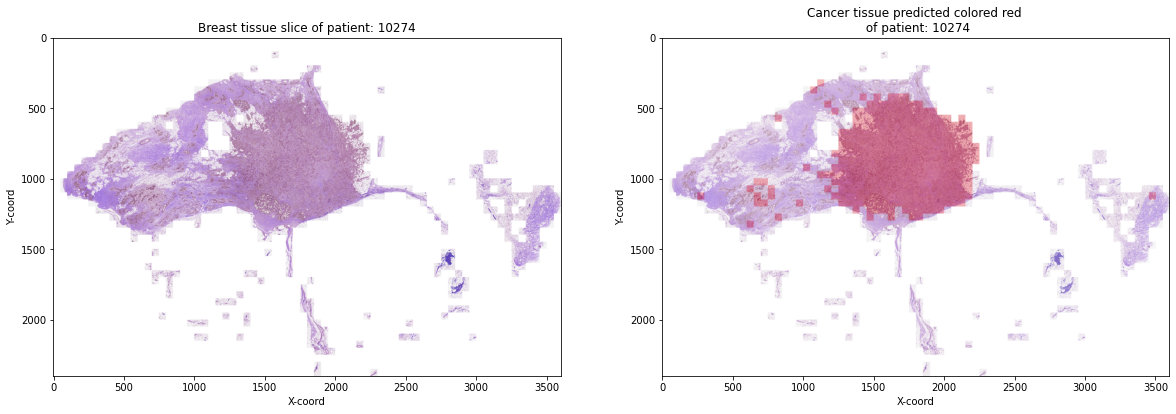

In [27]:
patient_id = "10274"
model = "AllLevelsUnlocked_CLAHE.h5"
realty_vs_predict(patient_id,model,"CLAHE")

In [28]:
from tensorflow.keras import layers
import tensorflow as tf

model = Sequential()
for layer in conv_base.layers:
  layer.trainable = True
  model.add(layer)

model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)      

In [29]:
inputs = keras.Input(shape=(50,50,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = model(x)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)
vgg_cut_model = keras.Model(inputs, outputs)
compile_model(vgg_cut_model)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 tf.__operators__.getitem_1   (None, 50, 50, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 50, 50, 3)        0         
 a)                                                              
                                                                 
 sequential_2 (Sequential)   (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/15
2955/2955 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.9688
Epoch 1: val_loss improved from inf to 0.63408, saving model to /content/models/AllLevelsUnlocked_plusblock5_CLAHE.h5
2955/2955 [==============================] - 149s 49ms/step - loss: 0.0856 - accuracy: 0.9688 - val_loss: 0.6341 - val_accuracy: 0.8272
Epoch 2/15
2955/2955 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9766
Epoch 2: val_loss did not improve from 0.63408
2955/2955 [==============================] - 163s 55ms/step - loss: 0.0638 - accuracy: 0.9766 - val_loss: 0.7540 - val_accuracy: 0.8347
Epoch 3/15
2954/2955 [============================>.] - ETA: 0s - loss: 0.0546 - accuracy: 0.9805
Epoch 3: val_loss improved from 0.63408 to 0.61406, saving model to /content/models/AllLevelsUnlocked_plusblock5_CLAHE.h5
2955/2955 [==============================] - 146s 49ms/step - loss: 0.0547 - accuracy: 0.9805 - val_loss: 0.6141 - val_accuracy: 0.8469
Epoch 4/15


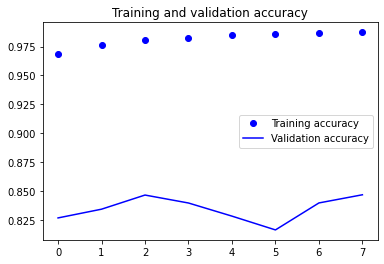

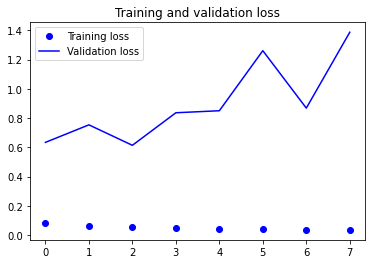

In [30]:
run_training(vgg_cut_model, 'AllLevelsUnlocked_plusblock5_CLAHE', num_epochs = 15, patience=5, monitor='val_loss')

1735/1735 [==============================] - 21s 12ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.9207    0.8665    0.8928     39748
           1     0.7068    0.8117    0.7557     15758

    accuracy                         0.8510     55506
   macro avg     0.8138    0.8391    0.8242     55506
weighted avg     0.8600    0.8510    0.8539     55506

Matrice di confusione:
[[34443  5305]
 [ 2967 12791]]
Classification report:
              precision    recall  f1-score   support

           0     0.9207    0.8665    0.8928     39748
           1     0.7068    0.8117    0.7557     15758

    accuracy                         0.8510     55506
   macro avg     0.8138    0.8391    0.8242     55506
weighted avg     0.8600    0.8510    0.8539     55506



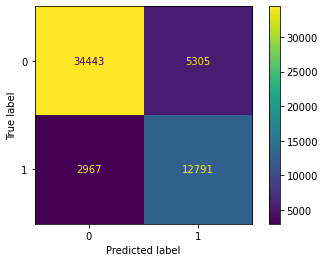

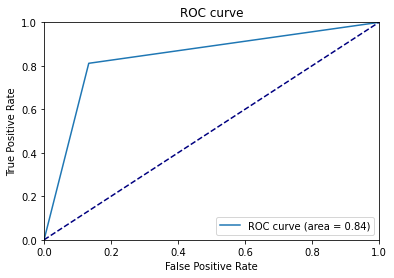

In [31]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/AllLevelsUnlocked_plusblock5_CLAHE.h5'),"AllLevelsUnlocked_plusblock5_CLAHE")

ciao
28/28 [==============================] - 1s 13ms/step


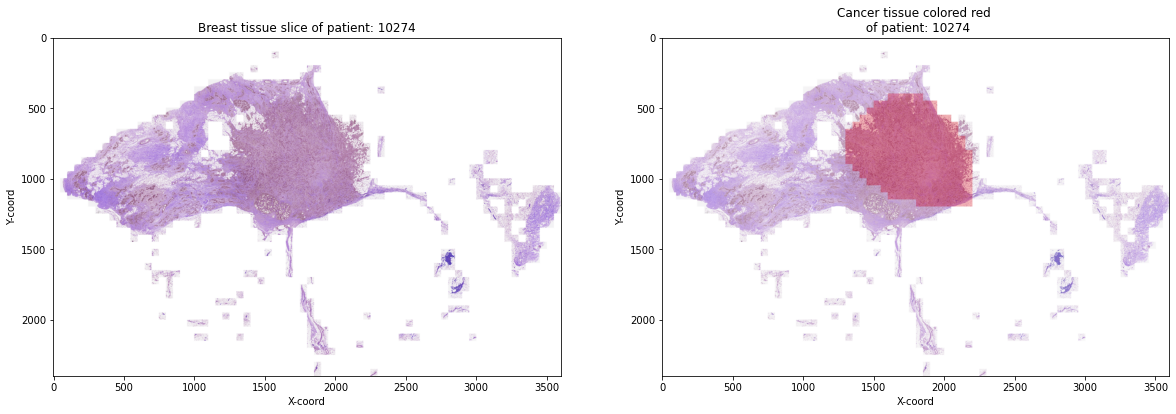

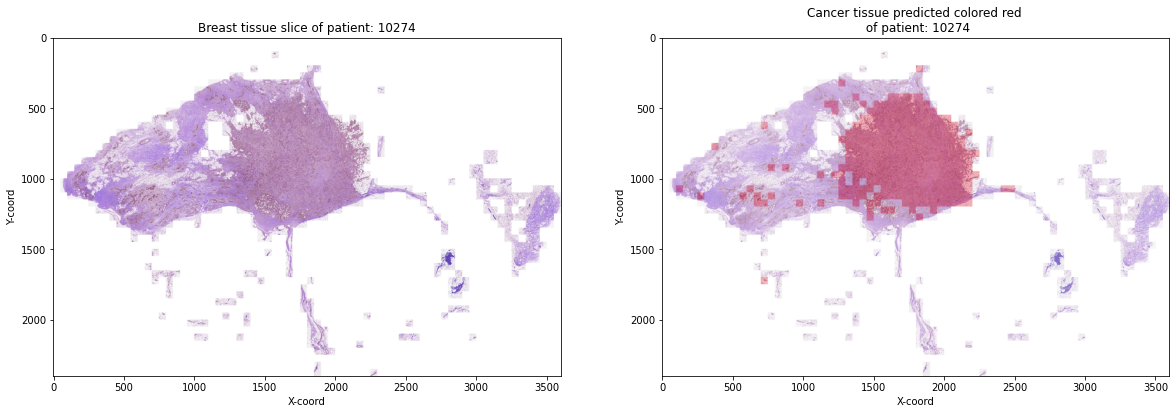

In [37]:
patient_id = "10274"
model = "AllLevelsUnlocked_plusblock5_CLAHE.h5"
realty_vs_predict(patient_id,model,"CLAHE")